This Exam Question 4

1. Make a function that can realize a multivariate standard Wiener process

(10, 1000)


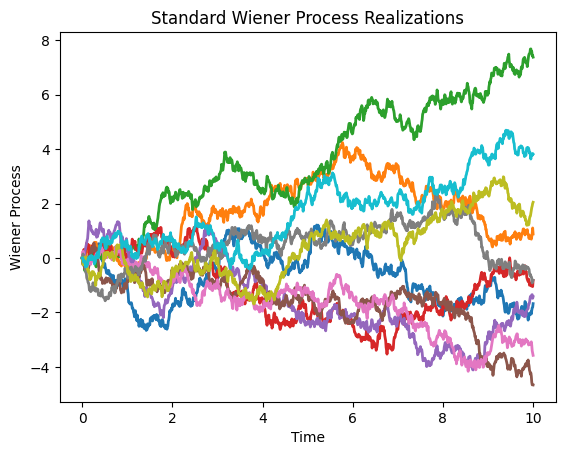

In [37]:
import numpy as np
import matplotlib.pyplot as plt

def scalar_std_wiener_process(T, N, Ns, seed=None):
    """
    Generates Ns realizations of a standard scalar Wiener process.
    
    Parameters:
    T : Final time.
    N : Number of intervals.
    Ns : Number of realizations.
    seed : int, optional
        Seed for the random number generator.
    
    Returns:
    W : ndarray
        Standard Wiener process in [0,T].
    Tw : ndarray
        Time points.
    dW : ndarray
        White noise used to generate the Wiener process.
    """
    if seed is not None:
        np.random.seed(seed)
    
    dt = T / N
    dW = np.sqrt(dt) * np.random.randn(Ns, N)
    W = np.hstack((np.zeros((Ns, 1)), np.cumsum(dW, axis=1)))
    Tw = np.linspace(0, T, N + 1)
    
    return W, Tw, dW


def StdWienerProcess(T, N, nW, Ns, seed=None):


    if seed is not None:
        np.random.seed(seed)
    
    dt = T / N
    dW = np.sqrt(dt) * np.random.randn(nW, N, Ns)
    W = np.concatenate((np.zeros((nW, 1, Ns)), np.cumsum(dW, axis=1)), axis=1)
    Tw = np.linspace(0, T, N + 1)
    
    return W, Tw, dW

# Example usage
T, N, Ns, seed = 10, 1000, 10, 100
W, Tw, dW = scalar_std_wiener_process(T, N, Ns, seed)
print(dW.shape)
plt.plot(Tw, W.T, linewidth=2)
plt.xlabel("Time")
plt.ylabel("Wiener Process")
plt.title("Standard Wiener Process Realizations")
plt.show()


2. Implement the explicit-explicit method with fixed step size

In [38]:
## import numpy as np

def SDEsolverExplicitExplicit(ffun, gfun, T, x0, W, *args):
    """
    Solves an SDE using an explicit-explicit Euler-Maruyama scheme.

    Parameters:
    ffun : function
        Drift function f(t, x, *args).
    gfun : function
        Diffusion function g(t, x, *args).
    T : ndarray
        Array of time points.
    x0 : ndarray
        Initial condition.
    W : ndarray
        Wiener process increments (same shape as T).
    *args : tuple
        Additional parameters for ffun and gfun.

    Returns:
    X : ndarray
        Solution of the SDE at end
    """
    # Number of timesteps
    N = len(T)
    # Number of dimensions of x
    nx = len(x0)
    # Allocating space for the solution 
    X = np.zeros((nx, N))
    # Storing the initial value in X
    X[:, 0] = x0


    for k in range(N - 1):
        # Timestep
        dt = T[k + 1] - T[k]
        # White noise 
        dW = W[:, k + 1] - W[:, k]
        
        # Evaluating the drift function
        f,_ = ffun(T[k], X[:, k], *args)
        
        # Evaluating the diffusion function
        g = gfun(T[k], X[:, k], *args)
        
        # SDE psi definition
        psi = X[:, k] + g * dW  

        # Explicit step to get Xk+1
        X[:, k + 1] = np.array(psi) + np.array(f) *np.array(dt)
    return X

def VanderpolDrift(t, x, p):
    mu = p[0]
    
    tmp = mu * (1.0 - x[0]**2)
    
    f = np.zeros(2)
    f[0] = x[1]
    f[1] = tmp * x[1] - x[0]
    
    if len(locals()) > 3:  # Check if we need the Jacobian matrix
        J = np.array([[0, 1], 
                      [-2 * mu * x[0] * x[1] - 1.0, tmp]])
        return f, J
    return f, []


def VanderPolDiffusion1(t, x, p):
    sigma = p[1]  # Assuming p is a list or numpy array
    g = np.array([0.0, sigma])
    return g



#def VanderPolDiffusion1_(t, x, p):
#    sigma = p[1]  # Extract sigma
#    g = np.array([[0.0], [sigma]])  # Reshape to (2,1)
#    return g


#this is from week 6



3. Implement the implicit-explicit method with fixed step size

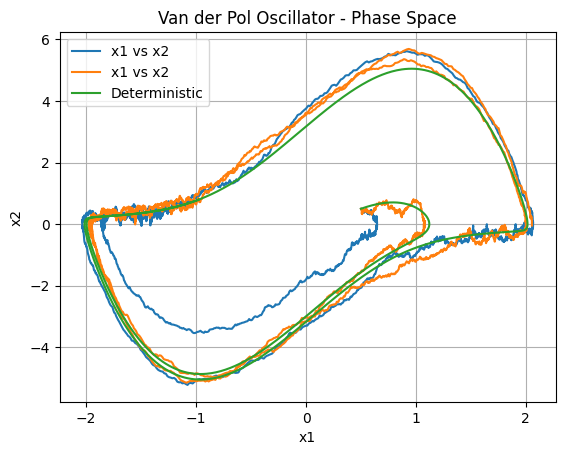

In [39]:
def SDEsolverImplicitExplicit(ffun, gfun, T, x0, W, *args):
    tol = 1.0e-8            # Tolerance
    maxit = 100             # Max iterations
    
    N = len(T)              # Time steps
    nx = len(x0)            # Dimensions of solution
    X = np.zeros((nx, N))   # Allocating space for solution over time
    X[:, 0] = x0            # Storing initial x in X
    
    for k in range(N - 1):
        # Evaluating the diffusion term
        g = gfun(T[k], X[:, k], *args)
        # Timestep
        dt = T[k + 1] - T[k]
        
        # Corresponding white noise
        dW = W[:, k + 1] - W[:, k]
        
        # SDE definition for psi
        psi = X[:, k] + g * dW

        # Evaluating the drift term
        f,_ = ffun(T[k], X[:, k], *args)

        # Using the explicit as initial guess
        xinit = np.array(psi) + np.array(f) * np.array(dt)

        # Implicit step
        X[:, k + 1] = SDENewtonSolver(
            ffun, T[k + 1], dt, psi, xinit, tol, maxit, *args
        )
    
    return X


def SDENewtonSolver(ffun, t, dt, psi, xinit, tol, maxit, *args):
    I = np.eye(len(xinit))      # Identity matrix size x
    x = xinit                   # Initial guess
    f, J = ffun(t, x, *args)    # Evaluating function for f val and jacobian
    R = x - f * dt - psi        # Residual function
    it = 1                      # Iteration count
    
    # While residual is larger than the tolerance
    while np.linalg.norm(R, np.inf) > tol and it <= maxit:
        # Jacobian of residual
        dRdx = I - J * dt   
        # Change in x
        mdx = np.linalg.solve(dRdx, R)
        # Update x
        x = x - mdx
        # Compute function value and jacobian
        f, J = ffun(t, x, *args)
        # Residual
        R = x - f * dt - psi
        # Iteration count
        it += 1
    #what is this one changing for each iteration? The step 

    return x


# Van der Pol parameter
mu = 3
# Noise value
sigma = 0.5
# Parameters
p = np.array([mu, sigma])
# Initial value 
x0 = np.array([0.5, 0.5])

# Time frame
tf = 5 * mu
# Dimensions of W(k)
nw = 2
# Number of intervals
N = 5000
# Number of realizations
Ns = 5
# Reproducability
seed = 100

# Generate standard Wiener process
W, T, dW = StdWienerProcess(tf, N,nw ,Ns, seed)
# Initialize solution array
X = np.zeros((len(x0), N + 1, Ns))

# Solve SDE for each sample path
for i in range(Ns):
    X[:, :, i] = SDEsolverImplicitExplicit(
        VanderpolDrift, VanderPolDiffusion1, T, x0, W[:, :, i], p
    )


# Solve deterministic case
Xd = SDEsolverImplicitExplicit(
    VanderpolDrift, VanderPolDiffusion1, T, x0, W[:, :, i], np.array([mu, 0.0])
)


plt.figure()
plt.plot(X[0,:, 0], X[1,:, 0], label='x1 vs x2')
plt.plot(X[0,:, 1], X[1,:, 1], label='x1 vs x2')
plt.plot(Xd[0,:,], Xd[1,:], label='Deterministic')

plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.title('Van der Pol Oscillator - Phase Space')
plt.grid()
plt.show()


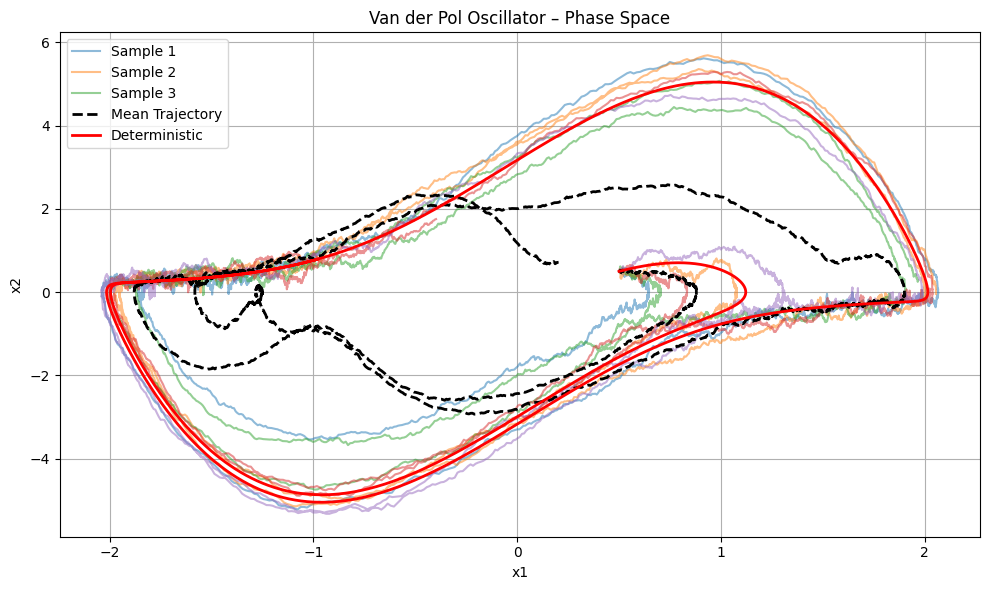

Describe the implementations and the idea we use in the deriving the methods


Explicite-Explicit:

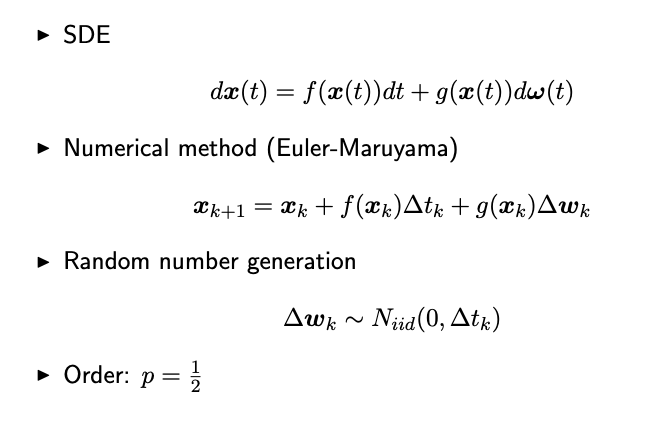


Implicit-Explicit:

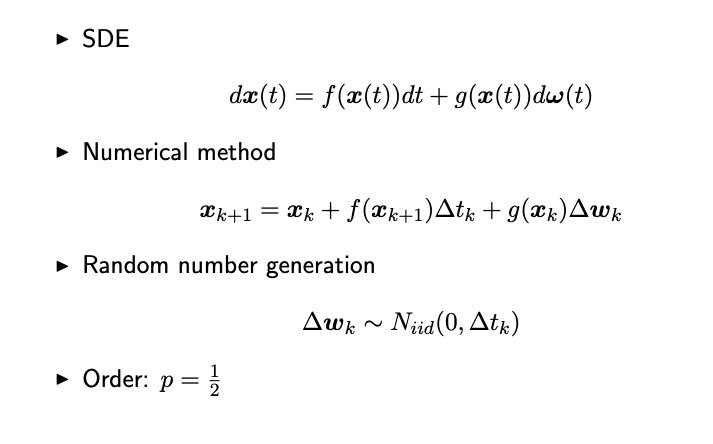

the big difference is that the implicit-explicit method has f(xk+1) term

Making SDE extensions of my test problems in 1.
This includes
- prey pred (done )
- van der pool (done)

- CSTR 3 state
- CSTR 1 state
- PFR 3 state
- PFR 1 state



[[-5.77829302e+03 -3.39734064e+03 -8.02149874e+00]
 [-6.79468128e+03 -9.17563366e+03 -1.60429975e+01]
 [ 4.54493731e+05  4.54493731e+05  3.45406258e+03]]


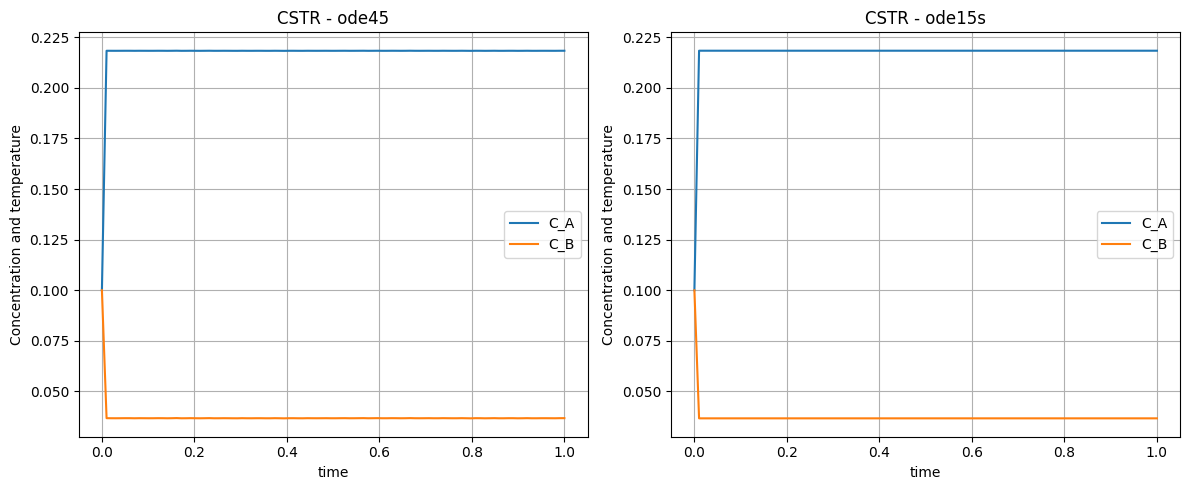

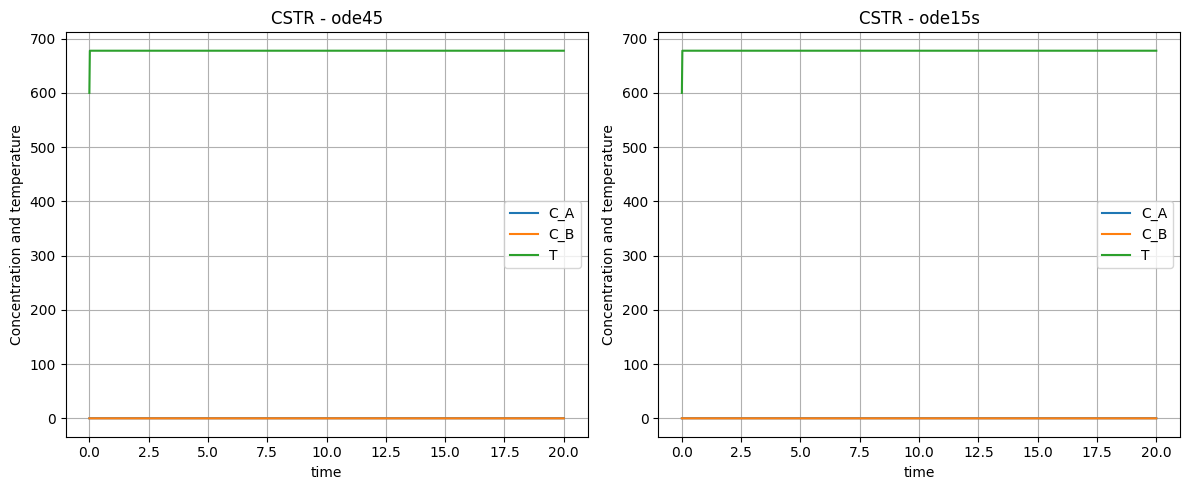

In [55]:

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot RK45 (ode45)
axs[0].plot(t_eval, sol_ode45.y[0], label='C_A')
axs[0].plot(t_eval, sol_ode45.y[1], label='C_B')
axs[0].plot(t_eval, sol_ode45.y[2], label='T')
axs[0].set_xlabel('time')
axs[0].set_ylabel('Concentration and temperature')
axs[0].set_title('CSTR - ode45')
axs[0].legend()
axs[0].grid()


# Plot BDF (ode15s)
axs[1].plot(t_eval, sol_ode15s.y[0], label='C_A')
axs[1].plot(t_eval, sol_ode15s.y[1], label='C_B')
axs[1].plot(t_eval, sol_ode15s.y[2], label='T')
axs[1].set_xlabel('time')
axs[1].set_ylabel('Concentration and temperature')
axs[1].set_title('CSTR - ode15s')
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()

Van der pool 
\begin{align}
dx_1(t) &= x_2(t) \, dt \\
dx_2(t) &= \left[ \mu \left(1 - x_1(t)^2\right) x_2(t) - x_1(t) \right] dt + \sigma \, dW(t)
\end{align}

where:

%\begin{itemize}
%  \item \( x_1(t) \) is the position,
%  \item \( x_2(t) \) is the velocity,
%  \item \( \mu > 0 \) controls the nonlinearity and damping,
%  \item \( \sigma \) is the noise intensity,
%  \item \( W(t) \) is a standard Wiener process.
%\end{itemize}



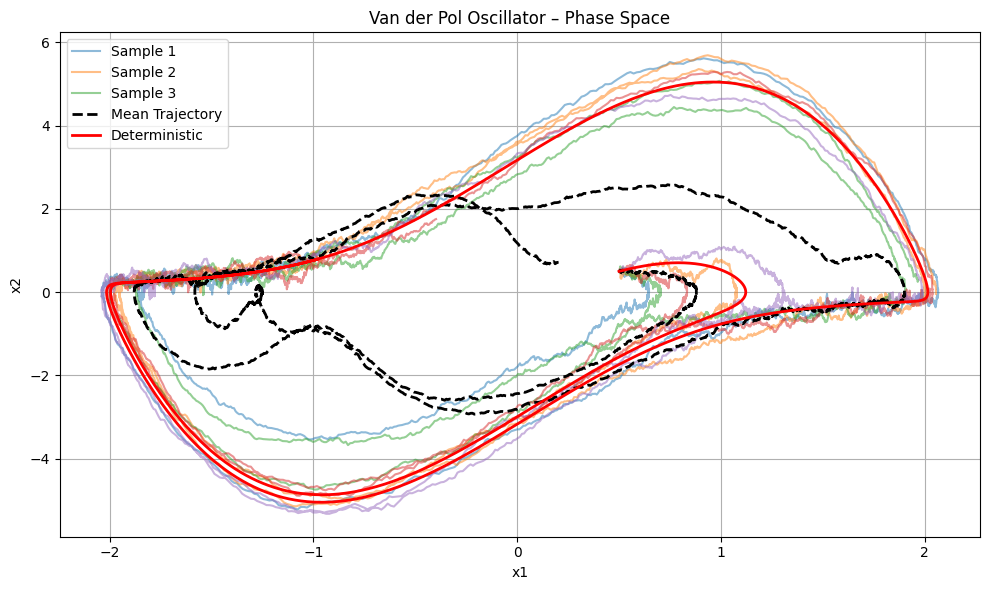

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
mu = 3
sigma = 0.5
p = np.array([mu, sigma])
x0 = np.array([0.5, 0.5])

tf = 5 * mu     # Final time
nw = 2          # Noise dimension
N = 5000        # Number of intervals
Ns = 5          # Number of sample paths
seed = 100      # Reproducibility

# Generate Wiener process: shape W = (nw, N+1, Ns)
W, T, dW = StdWienerProcess(tf, N, nw, Ns, seed)

# Storage for solutions: shape (state_dim, time_steps, samples)
X = np.zeros((len(x0), N + 1, Ns))

# Solve SDE for each realization
for i in range(Ns):
    X[:, :, i] = SDEsolverImplicitExplicit(
        VanderpolDrift, VanderPolDiffusion1, T, x0, W[:, :, i], p
    )

# Solve deterministic system (σ = 0)
Xd = SDEsolverImplicitExplicit(
    VanderpolDrift, VanderPolDiffusion1, T, x0, W[:, :, 0], np.array([mu, 0.0])
)

# Compute mean trajectory over Ns realizations
X_mean = np.mean(X, axis=2)

# === Plotting ===

plt.figure(figsize=(10, 6))

# Plot sample paths in phase space
for i in range(Ns):
    plt.plot(X[0, :, i], X[1, :, i], alpha=0.5, label=f'Sample {i+1}' if i < 3 else None)

# Mean trajectory
plt.plot(X_mean[0], X_mean[1], 'k--', label='Mean Trajectory', linewidth=2)

# Deterministic solution
plt.plot(Xd[0], Xd[1], 'r', label='Deterministic', linewidth=2)

plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Van der Pol Oscillator – Phase Space')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


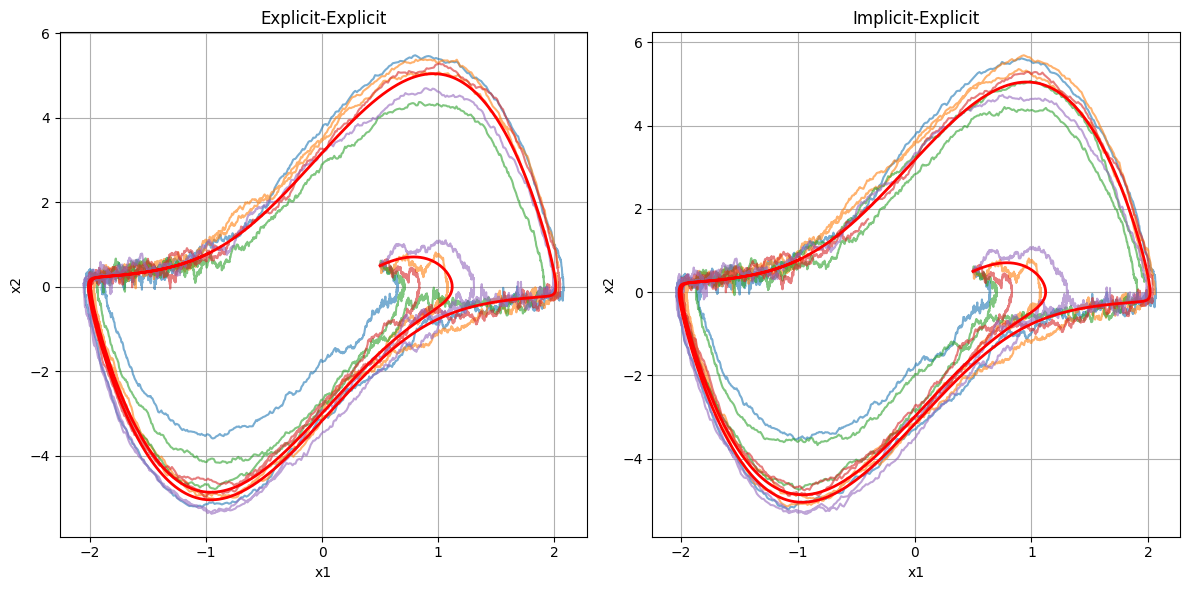

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
mu = 3
sigma = 0.5
p = np.array([mu, sigma])
x0 = np.array([0.5, 0.5])

tf = 5 * mu     # Final time
nw = 2          # Noise dimension
N = 5000        # Time steps
Ns = 5          # Number of sample paths
seed = 100      # Reproducibility

# Generate Wiener process (shape: W = (nw, N+1, Ns))
W, T, dW = StdWienerProcess(tf, N, nw, Ns, seed)

# Allocate space for solutions
X_exp = np.zeros((len(x0), N + 1, Ns))
X_imp = np.zeros((len(x0), N + 1, Ns))

# Solve for each sample path
for i in range(Ns):
    Wi = W[:, :, i]
    X_exp[:, :, i] = SDEsolverExplicitExplicit(VanderpolDrift, VanderPolDiffusion1, T, x0, Wi, p)
    X_imp[:, :, i] = SDEsolverImplicitExplicit(VanderpolDrift, VanderPolDiffusion1, T, x0, Wi, p)

# Solve deterministic system (σ = 0)
Xd = SDEsolverImplicitExplicit(
    VanderpolDrift, VanderPolDiffusion1, T, x0, W[:, :, 0], np.array([mu, 0.0])
)
# Plot results
plt.figure(figsize=(12, 6))

# Explicit-Explicit
plt.subplot(1, 2, 1)
for i in range(Ns):
    plt.plot(X_exp[0, :, i], X_exp[1, :, i], alpha=0.6)



plt.plot(Xd[0], Xd[1], 'r', label='Deterministic', linewidth=2)

plt.title('Explicit-Explicit')
plt.xlabel('x1')
plt.ylabel('x2')
plt.grid()

# Implicit-Explicit
plt.subplot(1, 2, 2)
for i in range(Ns):
    plt.plot(X_imp[0, :, i], X_imp[1, :, i], alpha=0.6)
plt.plot(Xd[0], Xd[1], 'r', label='Deterministic', linewidth=2)

plt.title('Implicit-Explicit')
plt.xlabel('x1')
plt.ylabel('x2')
plt.grid()

plt.tight_layout()
plt.show()


Next Prey pred:

additive noise, state independent
\begin{align*}
dx_1(t) &= a(1 - x_2(t))x_1(t) \, dt + \sigma_1 \, dW_1(t) \\
dx_2(t) &= -b(1 - x_1(t))x_2(t) \, dt + \sigma_2 \, dW_2(t)
\end{align*}

For multiplicative noise, state dependent (makes more sense for prey pred)

\begin{align*}
dx_1(t) &= a(1 - x_2(t)) \, x_1(t) \, dt + \sigma_1 \, x_1(t) \, dW_1(t) \\
dx_2(t) &= -b(1 - x_1(t)) \, x_2(t) \, dt + \sigma_2 \, x_2(t) \, dW_2(t)
\end{align*}

[1.01054174 0.49584509]
[0.50946959 0.00261354]
[1.00304174 0.49584509]
0.015
[1.01068426 0.49588482]
[0.50950128 0.00264908]
[1.00304174 0.49584509]
0.015
[1.01689299 0.49120291]
[0.5173922  0.00414894]
[1.00925047 0.49116317]
0.015
[1.01701191 0.49122585]
[0.51742937 0.00417835]
[1.00925047 0.49116317]
0.015
[1.02193551 0.49693421]
[0.5141008  0.00545025]
[1.01417407 0.49687153]
0.015
[1.02188491 0.4969531 ]
[0.51405604 0.00543789]
[1.01417407 0.49687153]
0.015
[1.02615246 0.49728906]
[0.51585807 0.00650266]
[1.01844161 0.49720749]
0.015
[1.02617944 0.49730513]
[0.51585514 0.00650959]
[1.01844161 0.49720749]
0.015
[1.0428925  0.50686296]
[0.51428892 0.01087031]
[1.03515467 0.50676532]
0.015
[1.0428678 0.5069283]
[0.5142086  0.01086545]
[1.03515467 0.50676532]
0.015
[1.05126019 0.51614043]
[0.5086623  0.01322873]
[1.04354706 0.51597745]
0.015
[1.05117583 0.51617557]
[0.50858455 0.01320786]
[1.04354706 0.51597745]
0.015
[1.05511991 0.5214161 ]
[0.5049634 0.0143702]
[1.04749114 0.521217

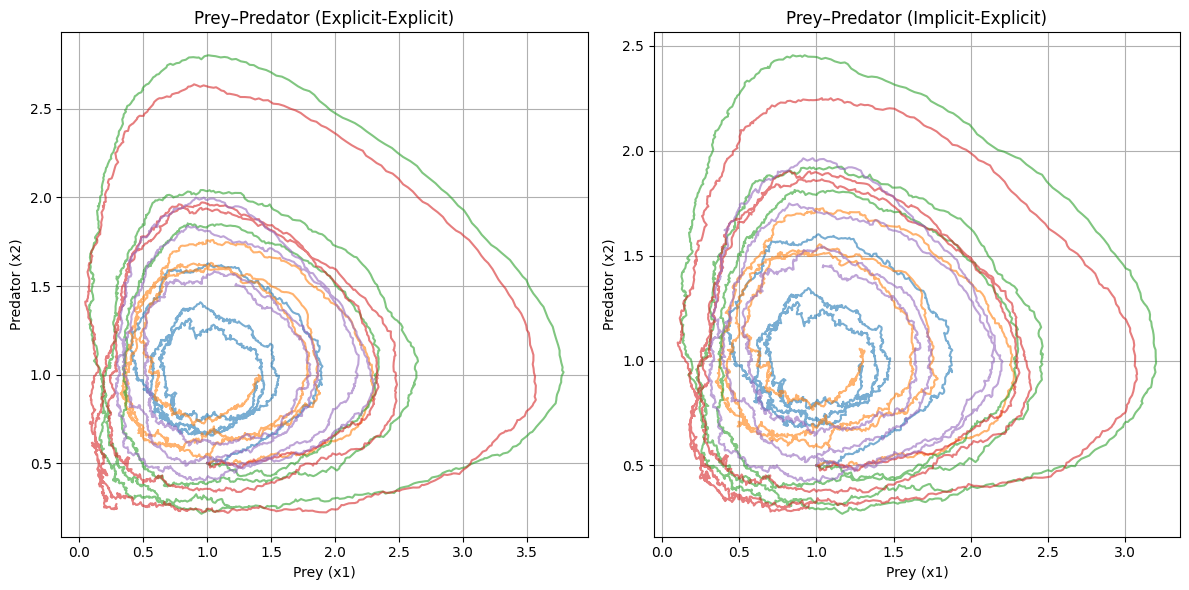

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# --- Prey-Predator Drift Function and Jacobian ---
def PreyPredator_Fun_Jac(t, x, a, b):
    x1, x2 = x
    dx1 = a * (1 - x2) * x1
    dx2 = -b * (1 - x1) * x2

    dx1x1 = a * (1 - x2)
    dx1x2 = -a * x1
    dx2x1 = b * x2
    dx2x2 = -b * (1 - x1)

    f = [dx1, dx2]
    J = [[dx1x1, dx1x2], [dx2x1, dx2x2]]
    return f, J

# --- Diffusion Function (Additive Noise) ---
def PreyPredatorDiffusion(t, x, sigma1, sigma2):
    return np.array([sigma1, sigma2])

# --- Newton Solver ---
def SDENewtonSolver(ffun, t, dt, psi, xinit, tol, maxit, *args):
    I = np.eye(len(xinit))
    x = xinit
    f, J = ffun(t, x, *args)
    f = np.array(f)
    print(x)
    print(f)
    print(psi)
    print(dt)

    R = x - f * dt - psi
    it = 1
    while np.linalg.norm(R, np.inf) > tol and it <= maxit:
        dRdx = I - np.array(J) * dt
        mdx = np.linalg.solve(dRdx, R)
        x = x - mdx
        f, J = ffun(t, x, *args)

        f = np.array(f)
        print(x)
        print(f)
        print(psi)
        print(dt)

        R = x - f * dt - psi
        it += 1
    return x

def SDEsolverExplicitExplicit(ffun, gfun, T, x0, W, fargs=(), gargs=()):
    N = len(T)
    nx = len(x0)
    X = np.zeros((nx, N))
    X[:, 0] = x0
    for k in range(N - 1):
        dt = T[k + 1] - T[k]
        dW = W[:, k + 1] - W[:, k]
        f, _ = ffun(T[k], X[:, k], *fargs)
        g = gfun(T[k], X[:, k], *gargs)
        psi = X[:, k] + g * dW
        X[:, k + 1] = np.array(psi) + np.array(f) * dt
    return X

def SDEsolverImplicitExplicit(ffun, gfun, T, x0, W, fargs=(), gargs=()):
    tol = 1e-8
    maxit = 100
    N = len(T)
    nx = len(x0)
    X = np.zeros((nx, N))
    X[:, 0] = x0
    for k in range(N - 1):
        dt = T[k + 1] - T[k]
        dW = W[:, k + 1] - W[:, k]
        g = gfun(T[k], X[:, k], *gargs)
        psi = X[:, k] + g * dW
        f, _ = ffun(T[k], X[:, k], *fargs)
        xinit = np.array(psi) + np.array(f) * dt
        X[:, k + 1] = SDENewtonSolver(ffun, T[k + 1], dt, psi, xinit, tol, maxit, *fargs)
    return X
# --- StdWienerProcess (Helper) ---
def StdWienerProcess(tf, N, nw, Ns, seed=0):
    np.random.seed(seed)
    dt = tf / N
    T = np.linspace(0, tf, N + 1)
    dW = np.random.normal(0.0, np.sqrt(dt), size=(nw, N, Ns))
    W = np.zeros((nw, N + 1, Ns))
    W[:, 1:, :] = np.cumsum(dW, axis=1)
    return W, T, dW

# --- Parameters ---
a, b = 1.0, 0.5
sigma1, sigma2 = 0.1, 0.1
x0 = np.array([1.0, 0.5])
tf = 30.0
N = 2000
nw = 2
Ns = 5
seed = 42
p_drift = [a, b]
p_diff = [sigma1, sigma2]

# --- Generate Wiener Process ---
W, T, dW = StdWienerProcess(tf, N, nw, Ns, seed)

# --- Allocate Solution Arrays ---
X_exp = np.zeros((2, N + 1, Ns))
X_imp = np.zeros((2, N + 1, Ns))

# --- Solve for each sample path ---
a, b = 1.0, 0.5
sigma1, sigma2 = 0.05, 0.05
fargs = (a, b)
gargs = (sigma1, sigma2)

for i in range(Ns):
    Wi = W[:, :, i]
    X_exp[:, :, i] = SDEsolverExplicitExplicit(
        PreyPredator_Fun_Jac, PreyPredatorDiffusion, T, x0.copy(), Wi, fargs, gargs
    )
    X_imp[:, :, i] = SDEsolverImplicitExplicit(
        PreyPredator_Fun_Jac, PreyPredatorDiffusion, T, x0.copy(), Wi, fargs, gargs
    )
# --- Plotting ---
plt.figure(figsize=(12, 6))

# Explicit-Explicit
plt.subplot(1, 2, 1)
for i in range(Ns):
    print(i)
    plt.plot(X_exp[0, :, i], X_exp[1, :, i], alpha=0.6)
plt.title('Prey–Predator (Explicit-Explicit)')
plt.xlabel('Prey (x1)')
plt.ylabel('Predator (x2)')
plt.grid()

# Implicit-Explicit
plt.subplot(1, 2, 2)
for i in range(Ns):
    plt.plot(X_imp[0, :, i], X_imp[1, :, i], alpha=0.6)
plt.title('Prey–Predator (Implicit-Explicit)')
plt.xlabel('Prey (x1)')
plt.ylabel('Predator (x2)')
plt.grid()

plt.tight_layout()
plt.show()

###spørge peter om jeg har fucket om med noget


/var/folders/q3/3rts4g613pv9wy5pq7tw8lkr0000gn/T/ipykernel_39298/1071065967.py:26: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x0[0], x0[1], 'ko', label='Initial State',color = "red",linewidth=10)
/var/folders/q3/3rts4g613pv9wy5pq7tw8lkr0000gn/T/ipykernel_39298/1071065967.py:40: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x0[0], x0[1], 'ko', label='Initial State',color = "red",linewidth=10)


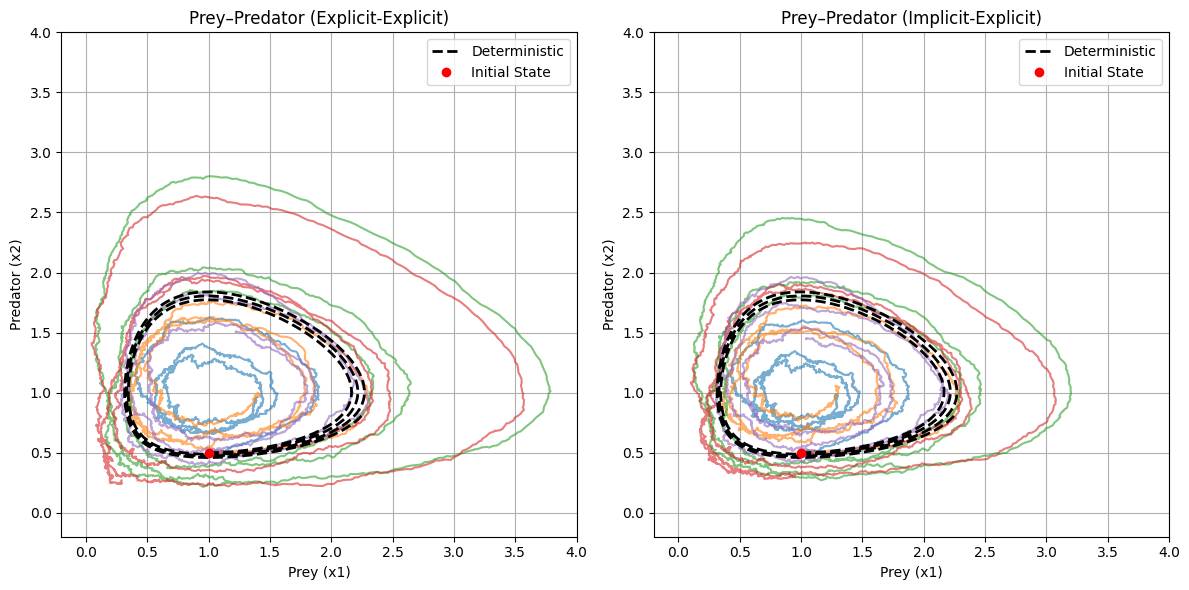

In [10]:
# --- Deterministic solution (same solver without noise) ---
def SDEsolverDeterministic(ffun, T, x0, fargs=()):
    N = len(T)
    nx = len(x0)
    X = np.zeros((nx, N))
    X[:, 0] = x0
    for k in range(N - 1):
        dt = T[k + 1] - T[k]
        f, _ = ffun(T[k], X[:, k], *fargs)
        X[:, k + 1] = X[:, k] + np.array(f) * dt
    return X

X_det = SDEsolverDeterministic(PreyPredator_Fun_Jac, T, x0, fargs)

# --- Plotting ---
plt.figure(figsize=(12, 6))

xlims = [-0.2, 4]
ylims = [-0.2, 4]

# Explicit-Explicit
plt.subplot(1, 2, 1)
for i in range(Ns):
    plt.plot(X_exp[0, :, i], X_exp[1, :, i], alpha=0.6)
plt.plot(X_det[0, :], X_det[1, :], 'k--', linewidth=2, label='Deterministic')
plt.plot(x0[0], x0[1], 'ko', label='Initial State',color = "red",linewidth=10)
plt.title('Prey–Predator (Explicit-Explicit)')
plt.xlabel('Prey (x1)')
plt.ylabel('Predator (x2)')
plt.xlim(xlims)
plt.ylim(ylims)
plt.grid()
plt.legend()

# Implicit-Explicit
plt.subplot(1, 2, 2)
for i in range(Ns):
    plt.plot(X_imp[0, :, i], X_imp[1, :, i], alpha=0.6)
plt.plot(X_det[0, :], X_det[1, :], 'k--', linewidth=2, label='Deterministic')
plt.plot(x0[0], x0[1], 'ko', label='Initial State',color = "red",linewidth=10)
plt.title('Prey–Predator (Implicit-Explicit)')
plt.xlabel('Prey (x1)')
plt.ylabel('Predator (x2)')
plt.xlim(xlims)
plt.ylim(ylims)
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


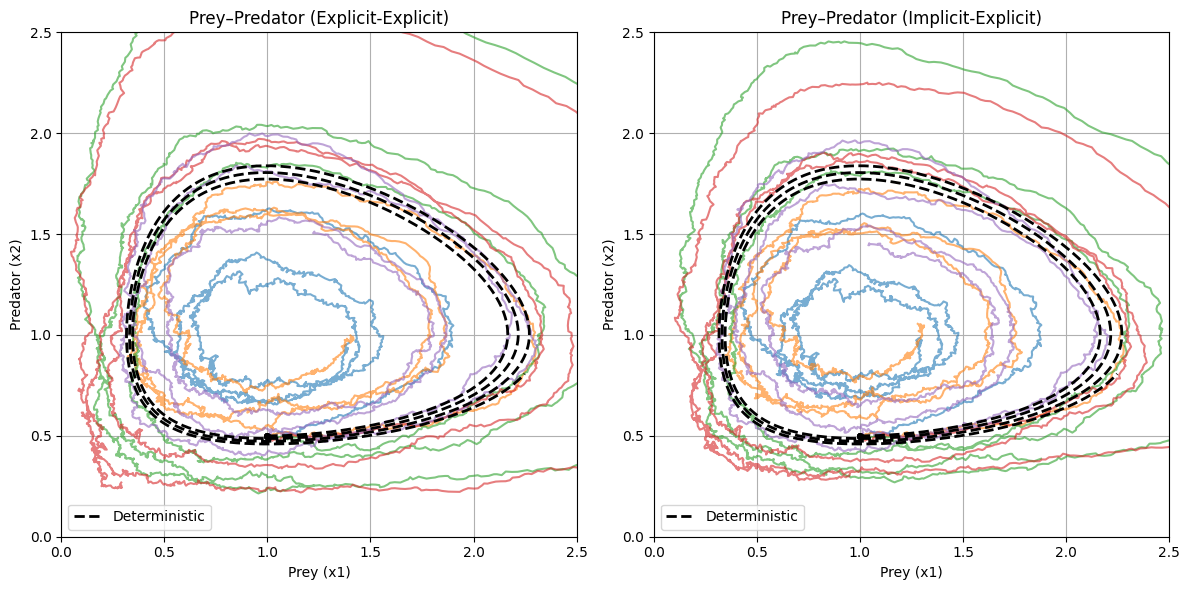

In [4]:
plt.figure(figsize=(12, 6))

xlims = [0, 2.5]
ylims = [0, 2.5]

# Explicit-Explicit
plt.subplot(1, 2, 1)
for i in range(Ns):
    plt.plot(X_exp[0, :, i], X_exp[1, :, i], alpha=0.6)
    plt.plot(X_exp[0, 0, i], X_exp[1, 0, i], 'ko', markersize=4)  # Start marker per path
plt.plot(X_det[0, :], X_det[1, :], 'k--', linewidth=2, label='Deterministic')
plt.title('Prey–Predator (Explicit-Explicit)')
plt.xlabel('Prey (x1)')
plt.ylabel('Predator (x2)')
plt.xlim(xlims)
plt.ylim(ylims)
plt.grid()
plt.legend(loc='lower left')

# Implicit-Explicit
plt.subplot(1, 2, 2)
for i in range(Ns):
    plt.plot(X_imp[0, :, i], X_imp[1, :, i], alpha=0.6)
    plt.plot(X_imp[0, 0, i], X_imp[1, 0, i], 'ko', markersize=4)  # Start marker per path
plt.plot(X_det[0, :], X_det[1, :], 'k--', linewidth=2, label='Deterministic')
plt.title('Prey–Predator (Implicit-Explicit)')
plt.xlabel('Prey (x1)')
plt.ylabel('Predator (x2)')
plt.xlim(xlims)
plt.ylim(ylims)
plt.grid()
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()


To do for the plot above:
- make the axes the same,
- add the starting point
- add the deterministic model

Notice that they are solved with the same seed


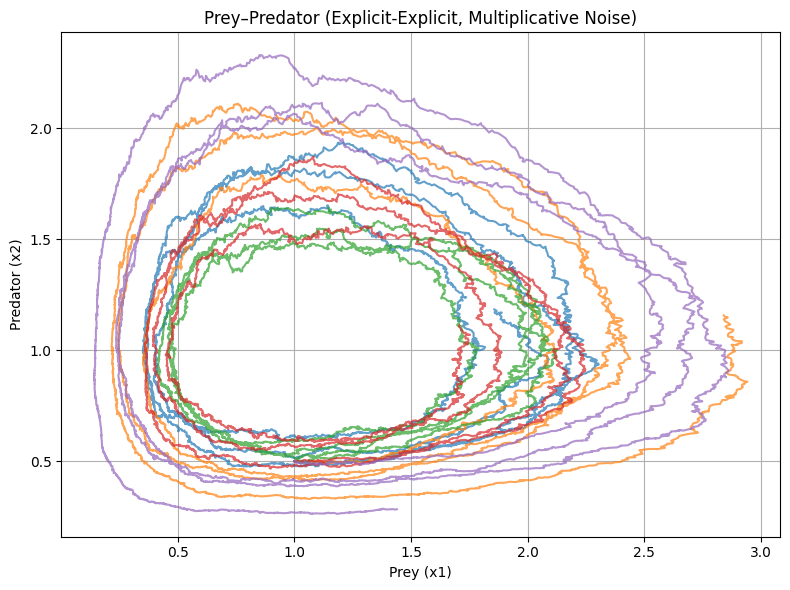

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# --- Drift function and Jacobian ---
def PreyPredator_Fun_Jac(t, x, a, b):
    x1, x2 = x
    dx1 = a * (1 - x2) * x1
    dx2 = -b * (1 - x1) * x2

    dx1x1 = a * (1 - x2)
    dx1x2 = -a * x1
    dx2x1 = b * x2
    dx2x2 = -b * (1 - x1)

    f = [dx1, dx2]
    J = [[dx1x1, dx1x2], [dx2x1, dx2x2]]
    return f, J

# --- Multiplicative noise diffusion ---
def PreyPredatorMultiplicativeDiffusion(t, x, sigma1, sigma2):
    x1, x2 = x
    return np.array([sigma1 * x1, sigma2 * x2])

# --- Explicit-explicit SDE solver ---
def SDEsolverExplicitExplicit(ffun, gfun, T, x0, W, fargs=(), gargs=()):
    N = len(T)
    nx = len(x0)
    X = np.zeros((nx, N))
    X[:, 0] = x0
    for k in range(N - 1):
        dt = T[k + 1] - T[k]
        dW = W[:, k + 1] - W[:, k]
        f, _ = ffun(T[k], X[:, k], *fargs)
        g = gfun(T[k], X[:, k], *gargs)
        X[:, k + 1] = X[:, k] + np.array(f) * dt + np.array(g) * dW
        X[:, k + 1] = np.clip(X[:, k + 1], 1e-6, 1e6)  # keep it bounded
    return X

# --- Wiener process generator ---
def StdWienerProcess(tf, N, nw, Ns, seed=0):
    np.random.seed(seed)
    dt = tf / N
    T = np.linspace(0, tf, N + 1)
    dW = np.random.normal(0.0, np.sqrt(dt), size=(nw, N, Ns))
    W = np.zeros((nw, N + 1, Ns))
    W[:, 1:, :] = np.cumsum(dW, axis=1)
    return W, T, dW

# --- Parameters ---
a, b = 1.0, 0.5
sigma1, sigma2 = 0.05, 0.05  # Mild multiplicative noise
x0 = np.array([1.0, 0.5])
tf = 30.0
N = 5000
nw = 2
Ns = 5
seed = 42
fargs = (a, b)
gargs = (sigma1, sigma2)

# --- Generate Wiener process ---
W, T, dW = StdWienerProcess(tf, N, nw, Ns, seed)

# --- Run explicit solver for each path ---
X = np.zeros((2, N + 1, Ns))
for i in range(Ns):
    Wi = W[:, :, i]
    X[:, :, i] = SDEsolverExplicitExplicit(
        PreyPredator_Fun_Jac,
        PreyPredatorMultiplicativeDiffusion,
        T,
        x0,
        Wi,
        fargs,
        gargs
    )

# --- Plotting ---
plt.figure(figsize=(8, 6))
for i in range(Ns):
    plt.plot(X[0, :, i], X[1, :, i], alpha=0.7)
plt.title('Prey–Predator (Explicit-Explicit, Multiplicative Noise)')
plt.xlabel('Prey (x1)')
plt.ylabel('Predator (x2)')
plt.grid()
plt.tight_layout()
plt.show()


In [15]:
# --- Newton solver (same as before) ---
def SDENewtonSolver(ffun, t, dt, psi, xinit, tol, maxit, *args):
    I = np.eye(len(xinit))
    x = xinit
    f, J = ffun(t, x, *args)
    f = np.array(f)
    R = x - f * dt - psi
    it = 1
    while np.linalg.norm(R, np.inf) > tol and it <= maxit:
        dRdx = I - np.array(J) * dt
        mdx = np.linalg.solve(dRdx, R)
        x = x - mdx
        f, J = ffun(t, x, *args)
        f = np.array(f)
        R = x - f * dt - psi
        it += 1
    return x

# --- Implicit-Explicit solver ---
def SDEsolverImplicitExplicit(ffun, gfun, T, x0, W, fargs=(), gargs=()):
    tol = 1e-8
    maxit = 100
    N = len(T)
    nx = len(x0)
    X = np.zeros((nx, N))
    X[:, 0] = x0
    for k in range(N - 1):
        dt = T[k + 1] - T[k]
        dW = W[:, k + 1] - W[:, k]
        g = gfun(T[k], X[:, k], *gargs)
        psi = X[:, k] + g * dW
        f, _ = ffun(T[k], X[:, k], *fargs)
        xinit = psi + np.array(f) * dt
        xnew = SDENewtonSolver(ffun, T[k + 1], dt, psi, xinit, tol, maxit, *fargs)
        X[:, k + 1] = np.clip(xnew, 1e-6, 1e6)  # keep bounded
    return X


In [16]:
# --- Allocate solution arrays ---
X_exp = np.zeros((2, N + 1, Ns))
X_imp = np.zeros((2, N + 1, Ns))

for i in range(Ns):
    Wi = W[:, :, i]
    X_exp[:, :, i] = SDEsolverExplicitExplicit(
        PreyPredator_Fun_Jac,
        PreyPredatorMultiplicativeDiffusion,
        T,
        x0,
        Wi,
        fargs,
        gargs
    )
    X_imp[:, :, i] = SDEsolverImplicitExplicit(
        PreyPredator_Fun_Jac,
        PreyPredatorMultiplicativeDiffusion,
        T,
        x0,
        Wi,
        fargs,
        gargs
    )


In [17]:
# --- Allocate solution arrays ---
X_exp = np.zeros((2, N + 1, Ns))
X_imp = np.zeros((2, N + 1, Ns))

for i in range(Ns):
    Wi = W[:, :, i]
    X_exp[:, :, i] = SDEsolverExplicitExplicit(
        PreyPredator_Fun_Jac,
        PreyPredatorMultiplicativeDiffusion,
        T,
        x0,
        Wi,
        fargs,
        gargs
    )
    X_imp[:, :, i] = SDEsolverImplicitExplicit(
        PreyPredator_Fun_Jac,
        PreyPredatorMultiplicativeDiffusion,
        T,
        x0,
        Wi,
        fargs,
        gargs
    )


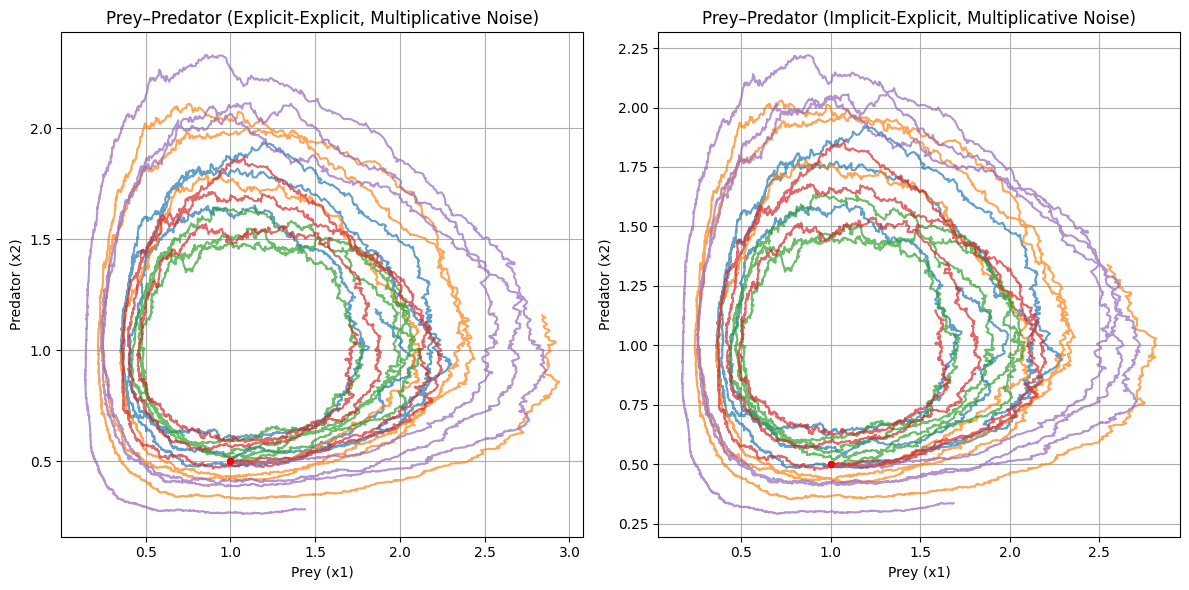

In [18]:
plt.figure(figsize=(12, 6))

# Explicit-Explicit
plt.subplot(1, 2, 1)
for i in range(Ns):
    plt.plot(X_exp[0, :, i], X_exp[1, :, i], alpha=0.7)
    plt.plot(X_exp[0, 0, i], X_exp[1, 0, i], 'ro', markersize=4)
plt.title('Prey–Predator (Explicit-Explicit, Multiplicative Noise)')
plt.xlabel('Prey (x1)')
plt.ylabel('Predator (x2)')
plt.grid()

# Implicit-Explicit
plt.subplot(1, 2, 2)
for i in range(Ns):
    plt.plot(X_imp[0, :, i], X_imp[1, :, i], alpha=0.7)
    plt.plot(X_imp[0, 0, i], X_imp[1, 0, i], 'ro', markersize=4)
plt.title('Prey–Predator (Implicit-Explicit, Multiplicative Noise)')
plt.xlabel('Prey (x1)')
plt.ylabel('Predator (x2)')
plt.grid()

plt.tight_layout()
plt.show()


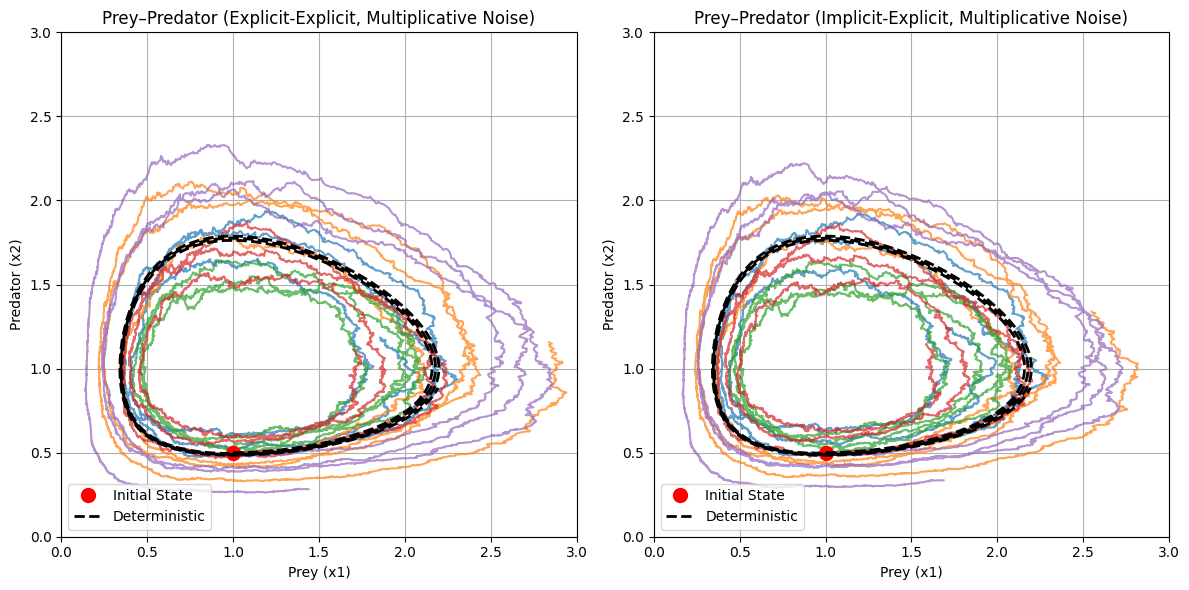

In [25]:
# --- Deterministic solution solver (Euler for ODE) ---
def DeterministicSolver(ffun, T, x0, fargs=()):
    N = len(T)
    nx = len(x0)
    X = np.zeros((nx, N))
    X[:, 0] = x0
    for k in range(N - 1):
        dt = T[k + 1] - T[k]
        f, _ = ffun(T[k], X[:, k], *fargs)
        X[:, k + 1] = X[:, k] + np.array(f) * dt
    return X

# --- Compute deterministic reference ---
X_det = DeterministicSolver(PreyPredator_Fun_Jac, T, x0, fargs)


plt.figure(figsize=(12, 6))
xlims = [0, 3]
ylims = [0, 3]

# --- Explicit-Explicit ---
plt.subplot(1, 2, 1)
for i in range(Ns):
    plt.plot(X_exp[0, :, i], X_exp[1, :, i], alpha=0.7)
plt.plot(X_exp[0, 0, 0], X_exp[1, 0, 0], 'ro', markersize=10, label='Initial State',linewidth=10)
plt.plot(X_det[0, :], X_det[1, :], 'k--', linewidth=2, label='Deterministic')
plt.title('Prey–Predator (Explicit-Explicit, Multiplicative Noise)')
plt.xlabel('Prey (x1)')
plt.ylabel('Predator (x2)')
plt.xlim(xlims)
plt.ylim(ylims)
plt.grid()
plt.legend(loc='lower left')

# --- Implicit-Explicit ---
plt.subplot(1, 2, 2)
for i in range(Ns):
    plt.plot(X_imp[0, :, i], X_imp[1, :, i], alpha=0.7)
plt.plot(X_imp[0, 0, 0], X_imp[1, 0, 0], 'ro', markersize=10, label='Initial State',linewidth=10)
plt.plot(X_det[0, :], X_det[1, :], 'k--', linewidth=2, label='Deterministic')
plt.title('Prey–Predator (Implicit-Explicit, Multiplicative Noise)')
plt.xlabel('Prey (x1)')
plt.ylabel('Predator (x2)')
plt.xlim(xlims)
plt.ylim(ylims)
plt.grid()
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()



It would make sense to add multiplicative noise, as it would be more realistic towards real life.

If the noise is set up, the problem explodes


Next up CSTR 3 -state

Deciding to do it like in the paper:

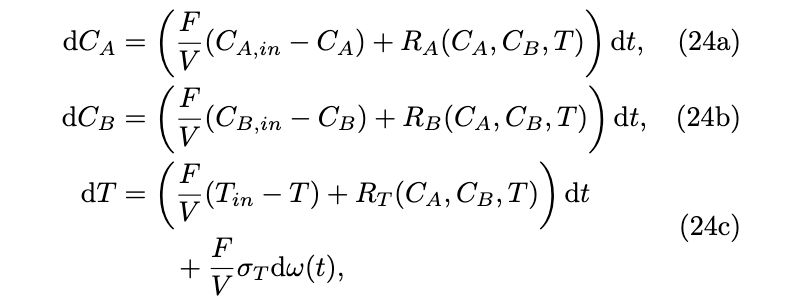



/var/folders/q3/3rts4g613pv9wy5pq7tw8lkr0000gn/T/ipykernel_23850/558329474.py:19: RuntimeWarning: overflow encountered in scalar multiply
  r = k * CA * CB
/var/folders/q3/3rts4g613pv9wy5pq7tw8lkr0000gn/T/ipykernel_23850/558329474.py:21: RuntimeWarning: invalid value encountered in add
  system = (C0 - C) * F / V + R


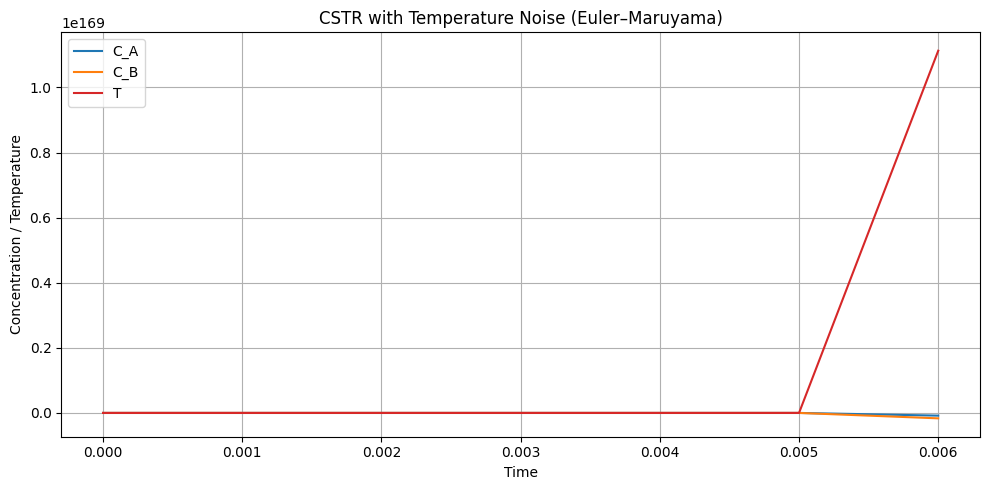

In [67]:
import numpy as np
import matplotlib.pyplot as plt

# --- Drift function (unchanged) ---
def CSTR(t, C, C0):
    deltaHr = -560
    rho = 1.0
    cp = 4.186
    E_adv_R = 8500
    k0 = np.exp(24.6)
    A = 0.1
    V = 0.105
    
    CA, CB, T = C
    k = k0 * np.exp(-E_adv_R / T)
    beta = -deltaHr / (rho * cp)
    v = np.array([-1, -2, beta])
    F = 250
    r = k * CA * CB
    R = v.T * r
    system = (C0 - C) * F / V + R
    return system  # [dCA, dCB, dT]

# --- SDE Euler-Maruyama with temperature noise only ---
def SDE_CSTR_temp_noise(CSTR, T, C0, Cin, sigma_T, seed=0):
    np.random.seed(seed)
    N = len(T)
    dt = T[1] - T[0]
    nx = len(C0)
    X = np.zeros((nx, N))
    X[:, 0] = C0
    for k in range(N - 1):
        drift = np.array(CSTR(T[k], X[:, k], Cin))
        dW = np.random.normal(0.0, np.sqrt(dt))  # 1D noise
        noise = np.array([0.0, 0.0, (250 / 0.105) * sigma_T * dW])
        X[:, k + 1] = X[:, k] + drift * dt + noise
    return X


def StdWienerProcess(T, N, nW, Ns, seed=None):
    """
    Generates Ns realizations of a standard Wiener process.
    
    Parameters:
    T    : Final time
    N    : Number of intervals
    nW   : Dimension of W(k)
    Ns   : Number of realizations
    seed : To set the random number generator (optional)
    
    Returns:
    W    : Standard Wiener process in [0,T]
    Tw   : Time points
    dW   : White noise used to generate the Wiener process
    """
    if seed is not None:
        np.random.seed(seed)
    
    dt = T / N
    dW = np.sqrt(dt) * np.random.randn(nW, N, Ns)
    W = np.concatenate((np.zeros((nW, 1, Ns)), np.cumsum(dW, axis=1)), axis=1)
    Tw = np.linspace(0, T, N + 1)
    
    return W, Tw, dW


# --- Parameters ---
Cin = np.array([1.6 / 2, 2.4 / 2, 600])
C0 = np.array([0.1, 0.1, 600])
t_span = (0, 1)
N = 1000
T = np.linspace(t_span[0], t_span[1], N + 1)
sigma_T = 0.5  # Noise intensity in temperature


# --- Simulate ---
X_sde = SDE_CSTR_temp_noise(CSTR, T, C0, Cin, sigma_T)

# --- Plotting ---
plt.figure(figsize=(10, 5))
plt.plot(T, X_sde[0], label='C_A')
plt.plot(T, X_sde[1], label='C_B')
plt.plot(T, X_sde[2], label='T', color='tab:red')
plt.xlabel('Time')
plt.ylabel('Concentration / Temperature')
plt.title('CSTR with Temperature Noise (Euler–Maruyama)')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


/var/folders/q3/3rts4g613pv9wy5pq7tw8lkr0000gn/T/ipykernel_23850/1594588862.py:19: RuntimeWarning: overflow encountered in scalar multiply
  r = k * CA * CB
/var/folders/q3/3rts4g613pv9wy5pq7tw8lkr0000gn/T/ipykernel_23850/1594588862.py:21: RuntimeWarning: invalid value encountered in add
  return (C0 - C) * F / V + R  # [dCA, dCB, dT]


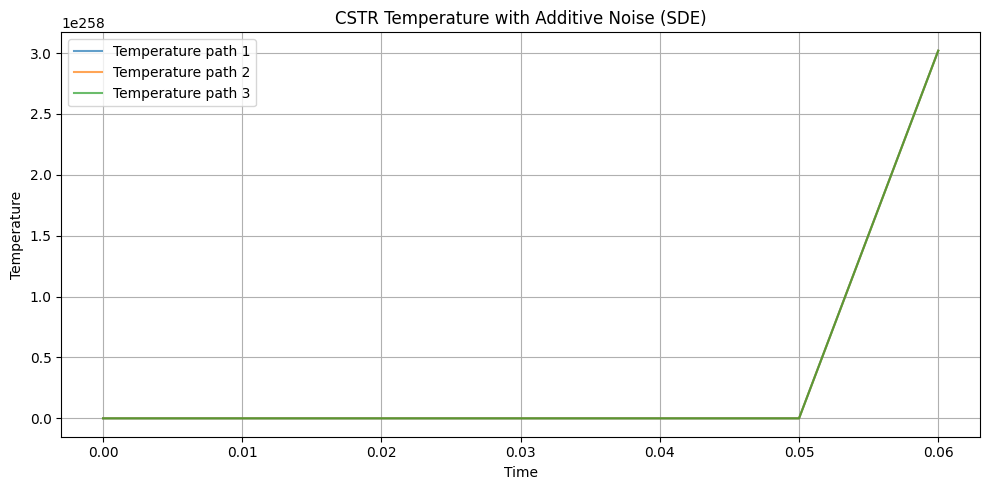

In [66]:
import numpy as np
import matplotlib.pyplot as plt

# --- Drift function ---
def CSTR(t, C, C0):
    deltaHr = -560
    rho = 1.0
    cp = 4.186
    E_adv_R = 8500
    k0 = np.exp(24.6)
    A = 0.1
    V = 0.105
    
    CA, CB, T = C
    k = k0 * np.exp(-E_adv_R / T)
    beta = -deltaHr / (rho * cp)
    v = np.array([-1, -2, beta])
    F = 250
    r = k * CA * CB
    R = v.T * r
    return (C0 - C) * F / V + R  # [dCA, dCB, dT]

# --- Standard Wiener process generator ---
def StdWienerProcess(T, N, nW, Ns, seed=None):
    if seed is not None:
        np.random.seed(seed)
    dt = T / N
    dW = np.sqrt(dt) * np.random.randn(nW, N, Ns)
    W = np.concatenate((np.zeros((nW, 1, Ns)), np.cumsum(dW, axis=1)), axis=1)
    Tw = np.linspace(0, T, N + 1)
    return W, Tw, dW

# --- SDE solver: noise only in temperature equation ---
def SDE_CSTR_temp_noise(CSTR, T, C0, Cin, W, sigma_T):
    nx, Np = len(C0), W.shape[1]
    X = np.zeros((nx, Np))
    X[:, 0] = C0
    dt = T[1] - T[0]
    F, V = 250, 0.105

    for k in range(Np - 1):
        drift = np.array(CSTR(T[k], X[:, k], Cin))
        dW_T = W[0, k + 1] - W[0, k]  # only using first Wiener process
        noise = np.array([0.0, 0.0, (F / V) * sigma_T * dW_T])
        X[:, k + 1] = X[:, k] + drift * dt + noise
    return X

# --- Parameters ---
Cin = np.array([1.6 / 2, 2.4 / 2, 600])
C0 = np.array([0.1, 0.1, 600])
tf = 1.0
N = 100
nw = 1         # 1D noise (only temperature)
Ns = 3         # number of sample paths
sigma_T = 0#1e-3
seed = 42

# --- Generate Wiener process ---
W, Tw, dW = StdWienerProcess(tf, N, nw, Ns, seed)

# --- Simulate for each realization ---
X_all = np.zeros((3, N + 1, Ns))
for i in range(Ns):
    X_all[:, :, i] = SDE_CSTR_temp_noise(CSTR, Tw, C0, Cin, W[:, :, i], sigma_T)

# --- Plotting ---
plt.figure(figsize=(10, 5))
for i in range(Ns):
    plt.plot(Tw, X_all[2, :, i], label=f'Temperature path {i+1}', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('CSTR Temperature with Additive Noise (SDE)')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()



[[-5.77829302e+03 -3.39734064e+03 -8.02149874e+00]
 [-6.79468128e+03 -9.17563366e+03 -1.60429975e+01]
 [ 4.54493731e+05  4.54493731e+05  3.45406258e+03]]


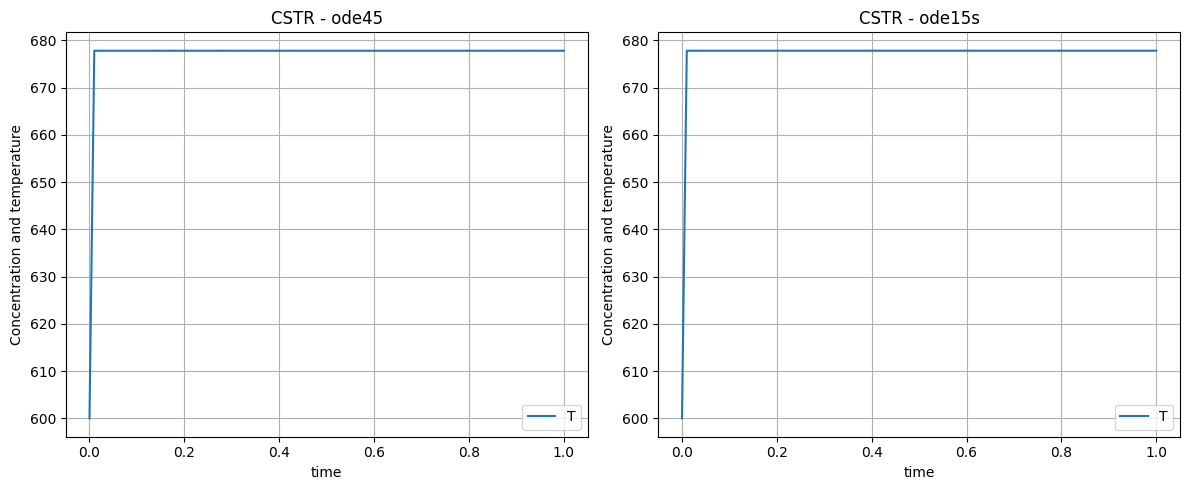

In [69]:
from scipy.integrate import solve_ivp


def CSTR(t, C, C0):
    # Given constants 
    deltaHr = -560              # kJ/mol
    rho = 1.0                   # kg/L
    cp = 4.186                  # kJ/(kg*K)
    E_adv_R = 8500              # E_a div med E
    k0 = np.exp(24.6)           # L/(mol*s)
    A = 0.1                     # m^2
    V = 0.105                   # L (according to a Wahlgreen (2020))
    
    CA, CB, T = C


    # Calculating constants
    k = k0 * np.exp(-E_adv_R/T)
    beta = - deltaHr/(rho*cp)
    v = np.array([-1, -2, beta])
    F = 250#v * A
    r=k*CA*CB
    
    # Reaction rate
    R = v.T*r #v transposed

    
    # Calculating the change in concentration
    system = (C0-C) * F/V + R
    dCA, dCB, dT = system

    return [dCA, dCB, dT]

def CSTR_Jac(t, C, C0):
    # Given constants 
    deltaHr = -560              # kJ/mol
    rho = 1.0                   # kg/L
    cp = 4.186                  # kJ/(kg*K)
    E_adv_R = 8500              # E_a div med R
    k0 = np.exp(24.6)           # L/(mol*s)
    A = 0.1                     # m^2
    V = 0.105                   # L (according to a Wahlgreen (2020))
    
    CA, CB, T = C
    # Calculating constants
    k = k0 * np.exp(-E_adv_R/T)
    beta = - deltaHr/(rho*cp)
    v = np.array([-1, -2, beta])

    #F = v * A
    F = 250

    r=k*CA*CB   

    Jac = np.array([
        [-F/V - k*CB,          -k*CA,         ((1/T**(2))*(E_adv_R))*(-r)],
        [-2*k*CB,              -F/V - 2*k*CA, ((1/T**(2))*(E_adv_R))*(-2*r)],
        [beta*k*CB,            beta*k*CA,     ((1/T**(2))*(E_adv_R))*(beta*r)+(F/V)]
    ])

    return Jac





Cin = np.array([1.6/2, 2.4/2, 600])  # inlet concentration
C0 = np.array([0.1, 0.1, 600])       # initial reactor state


t_span = (0, 1)
t_eval = np.linspace(t_span[0], t_span[1], 100)  

sol_ode45 = solve_ivp(CSTR, t_span, C0, args=(Cin,), t_eval=t_eval, method='RK45')
sol_ode15s = solve_ivp(CSTR, t_span, C0, args=(Cin,), t_eval=t_eval, method='BDF', jac=CSTR_Jac)

print(CSTR_Jac(1,C0,Cin))



fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot RK45 (ode45)
#axs[0].plot(t_eval, sol_ode45.y[0], label='C_A')
#axs[0].plot(t_eval, sol_ode45.y[1], label='C_B')
axs[0].plot(t_eval, sol_ode45.y[2], label='T')
axs[0].set_xlabel('time')
axs[0].set_ylabel('Concentration and temperature')
axs[0].set_title('CSTR - ode45')
axs[0].legend()
axs[0].grid()


# Plot BDF (ode15s)
#axs[1].plot(t_eval, sol_ode15s.y[0], label='C_A')
#axs[1].plot(t_eval, sol_ode15s.y[1], label='C_B')
axs[1].plot(t_eval, sol_ode15s.y[2], label='T')
axs[1].set_xlabel('time')
axs[1].set_ylabel('Concentration and temperature')
axs[1].set_title('CSTR - ode15s')
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show() 

In [72]:
sigma_T = 0.0  # Turn off noise

# Simulate ODE
from scipy.integrate import solve_ivp

sol_ode = solve_ivp(CSTR, t_span, C0, args=(Cin,), t_eval=t_eval)
T_ode = sol_ode.y[2]
tf = 1.0
N = 100
nw = 1         # 1D noise (only temperature)
Ns = 3         # number of sample paths
sigma_T = 0#1e-3
seed = 42

# --- Generate Wiener process ---

# Simulate SDE (should match)
W, Tw, dW = StdWienerProcess(tf, N, nw, Ns, seed)

X_sde = SDE_CSTR_temp_noise(CSTR, Tw, C0, Cin, W[:, :, 0], sigma_T)
T_sde = X_sde[2]

# Plot comparison
plt.plot(Tw, T_ode, label='ODE (no noise)', linestyle='--')
plt.plot(Tw, T_sde, label='SDE (σ=0)', alpha=0.7)
plt.legend()
plt.title('Temperature — ODE vs SDE (σ=0)')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.grid()
plt.show()


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

/var/folders/q3/3rts4g613pv9wy5pq7tw8lkr0000gn/T/ipykernel_23850/3237457485.py:21: RuntimeWarning: overflow encountered in scalar multiply
  r = k * CA * CB
/var/folders/q3/3rts4g613pv9wy5pq7tw8lkr0000gn/T/ipykernel_23850/3237457485.py:23: RuntimeWarning: invalid value encountered in add
  return (C0 - C) * F / V + R


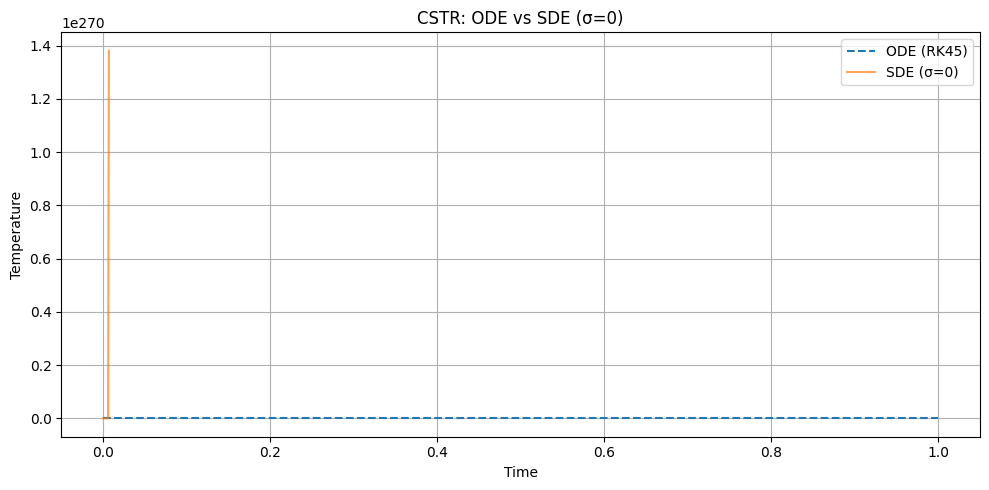

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# --- CSTR Drift Function ---
def CSTR(t, C, C0):
    deltaHr = -560              # kJ/mol
    rho = 1.0                   # kg/L
    cp = 4.186                  # kJ/(kg*K)
    E_adv_R = 8500              # activation energy over R
    k0 = np.exp(24.6)           # L/(mol*s)
    V = 0.105                   # reactor volume
    F = 250                     # flow rate

    CA, CB, T = C
    T = np.clip(T, 300, 2000)   # prevent overflow in exp

    k = k0 * np.exp(-E_adv_R / T)
    beta = -deltaHr / (rho * cp)
    v = np.array([-1, -2, beta])
    r = k * CA * CB
    R = v.T * r
    return (C0 - C) * F / V + R

# --- Standard Wiener Process ---
def StdWienerProcess(T, N, nW, Ns, seed=None):
    if seed is not None:
        np.random.seed(seed)
    dt = T / N
    dW = np.sqrt(dt) * np.random.randn(nW, N, Ns)
    W = np.concatenate((np.zeros((nW, 1, Ns)), np.cumsum(dW, axis=1)), axis=1)
    Tw = np.linspace(0, T, N + 1)
    return W, Tw, dW

# --- SDE Euler-Maruyama Solver with Temperature Noise ---
def SDE_CSTR_temp_noise(CSTR, T, C0, Cin, W, sigma_T):
    nx = len(C0)
    N = len(T)
    X = np.zeros((nx, N))
    X[:, 0] = C0
    dt = T[1] - T[0]
    F, V = 250, 0.105

    for k in range(N - 1):
        drift = np.array(CSTR(T[k], X[:, k], Cin))
        dW_T = float(W[k + 1] - W[k])  # scalar noise
        noise = np.array([0.0, 0.0, (F / V) * sigma_T * dW_T])
        X[:, k + 1] = X[:, k] + drift * dt + noise
    return X

# --- Setup ---
Cin = np.array([0.8, 1.2, 600])     # inlet state
C0 = np.array([0.1, 0.1, 600])      # initial state
t_span = (0, 1.0)
N = 1000
t_eval = np.linspace(*t_span, N + 1)
sigma_T = 0.0                      # <-- Set to 0.0 for comparison
nw = 1
Ns = 1
seed = 42

# --- ODE Solver ---
sol_ode = solve_ivp(CSTR, t_span, C0, args=(Cin,), t_eval=t_eval)
T_ode = sol_ode.y[2]

# --- SDE Solver ---
W, Tw, dW = StdWienerProcess(t_span[1], N, nw, Ns, seed)
W1 = W[0, :, 0]
X_sde = SDE_CSTR_temp_noise(CSTR, Tw, C0, Cin, W1, sigma_T)
T_sde = X_sde[2]

# --- Plot ---
plt.figure(figsize=(10, 5))
plt.plot(t_eval, T_ode, label='ODE (RK45)', linestyle='--')
plt.plot(Tw, T_sde, label='SDE (σ=0)', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('CSTR: ODE vs SDE (σ=0)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


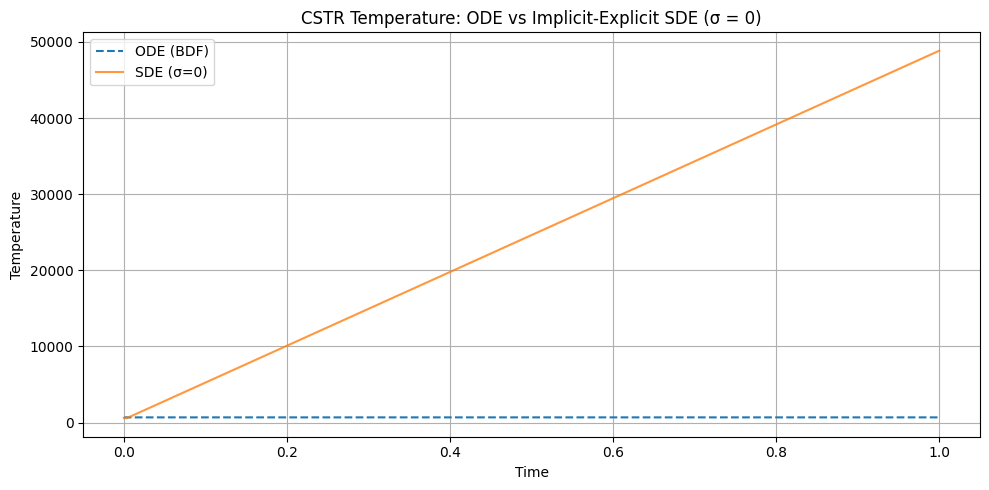

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Drift + Jacobian
def CSTR_Fun_Jac(t, C, C0):
    deltaHr = -560
    rho = 1.0
    cp = 4.186
    E_adv_R = 8500
    k0 = np.exp(24.6)
    V = 0.105
    F = 250
    CA, CB, T = C
    T = np.clip(T, 300, 2000)
    k = k0 * np.exp(-E_adv_R / T)
    beta = -deltaHr / (rho * cp)
    r = k * CA * CB
    f = (C0 - C) * F / V + np.array([-r, -2*r, beta * r])

    J = np.array([
        [-F / V - k * CB,      -k * CA,         beta * k * CB],
        [-2 * k * CB,          -F / V - 2 * k * CA, beta * k * CA],
        [beta * k * CB,        beta * k * CA,   F / V + beta * r * (E_adv_R / T**2)]
    ])
    return f, J

# Diffusion: temperature only
def CSTR_TemperatureNoise(t, x, sigma_T):
    return np.array([0.0, 0.0, sigma_T])

# Newton solver
def SDENewtonSolver(ffun, t, dt, psi, xinit, tol, maxit, *args):
    I = np.eye(len(xinit))
    x = xinit
    f, J = ffun(t, x, *args)
    f = np.array(f)
    R = x - f * dt - psi
    it = 1
    while np.linalg.norm(R, np.inf) > tol and it <= maxit:
        dRdx = I - np.array(J) * dt
        dx = np.linalg.solve(dRdx, R)
        x = x - dx
        f, J = ffun(t, x, *args)
        f = np.array(f)
        R = x - f * dt - psi
        it += 1
    return x

# Implicit-explicit SDE solver
def SDEsolverImplicitExplicit(ffun, gfun, T, x0, W, fargs=(), gargs=()):
    tol = 1e-8
    maxit = 100
    N = len(T)
    nx = len(x0)
    X = np.zeros((nx, N))
    X[:, 0] = x0
    for k in range(N - 1):
        dt = T[k + 1] - T[k]
        dW = W[:, k + 1] - W[:, k]
        g = gfun(T[k], X[:, k], *gargs)
        psi = X[:, k] + g * dW
        f, _ = ffun(T[k], X[:, k], *fargs)
        xinit = psi + f * dt
        X[:, k + 1] = SDENewtonSolver(ffun, T[k + 1], dt, psi, xinit, tol, maxit, *fargs)
    return X

# Standard Wiener process
def StdWienerProcess(T, N, nW, Ns, seed=None):
    if seed is not None:
        np.random.seed(seed)
    dt = T / N
    dW = np.sqrt(dt) * np.random.randn(nW, N, Ns)
    W = np.concatenate((np.zeros((nW, 1, Ns)), np.cumsum(dW, axis=1)), axis=1)
    Tw = np.linspace(0, T, N + 1)
    return W, Tw, dW

# Setup
Cin = np.array([0.8, 1.2, 600])
C0 = np.array([0.1, 0.1, 600])
tf = 1.0
N = 1000
nw = 1
sigma_T = 0.0
seed = 42

# Generate Wiener process
W, T, dW = StdWienerProcess(tf, N, nw, 1, seed)
W1 = W[0:1, :, 0]  # shape (1, N+1)

# Run SDE
X_sde = SDEsolverImplicitExplicit(CSTR_Fun_Jac, CSTR_TemperatureNoise, T, C0, W1, fargs=(Cin,), gargs=(sigma_T,))
T_sde = X_sde[2]

# Run ODE (BDF)
def CSTR(t, C, C0): return CSTR_Fun_Jac(t, C, C0)[0]
sol_ode = solve_ivp(CSTR, (0, tf), C0, args=(Cin,), t_eval=T, method='BDF')
T_ode = sol_ode.y[2]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(T, T_ode, label='ODE (BDF)', linestyle='--')
plt.plot(T, T_sde, label='SDE (σ=0)', alpha=0.8)
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('CSTR Temperature: ODE vs Implicit-Explicit SDE (σ = 0)')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


In [76]:
# Corrected Jacobian implementation for the CSTR drift function

def CSTR_Fun_Jac_Corrected(t, C, Cin):
    deltaHr = -560
    rho = 1.0
    cp = 4.186
    E_adv_R = 8500  # E_a / R_c
    k0 = np.exp(24.6)
    V = 0.105
    F = 250

    CA, CB, T = C
    T = np.clip(T, 300, 2000)  # Prevent numerical instability

    k = k0 * np.exp(-E_adv_R / T)
    r = k * CA * CB
    beta = -deltaHr / (rho * cp)

    RA = -r
    RB = -2 * r
    RT = beta * r

    dfdCA = -F / V - k * CB
    dfdCB = -k * CA
    dfdT1 = (E_adv_R / T**2) * RA

    dgdCA = -2 * k * CB
    dgdCB = -F / V - 2 * k * CA
    dfdT2 = (E_adv_R / T**2) * RB

    dTdCA = beta * k * CB
    dTdCB = beta * k * CA
    dTdT = -F / V + (E_adv_R / T**2) * RT

    f = (Cin - C) * F / V + np.array([RA, RB, RT])

    J = np.array([
        [dfdCA, dfdCB, dfdT1],
        [dgdCA, dgdCB, dfdT2],
        [dTdCA, dTdCB, dTdT]
    ])

    return f, J


In [77]:
X_sde = SDEsolverImplicitExplicit(
    CSTR_Fun_Jac_Corrected, 
    CSTR_TemperatureNoise, 
    T, 
    C0, 
    W1, 
    fargs=(Cin,), 
    gargs=(sigma_T,)
)

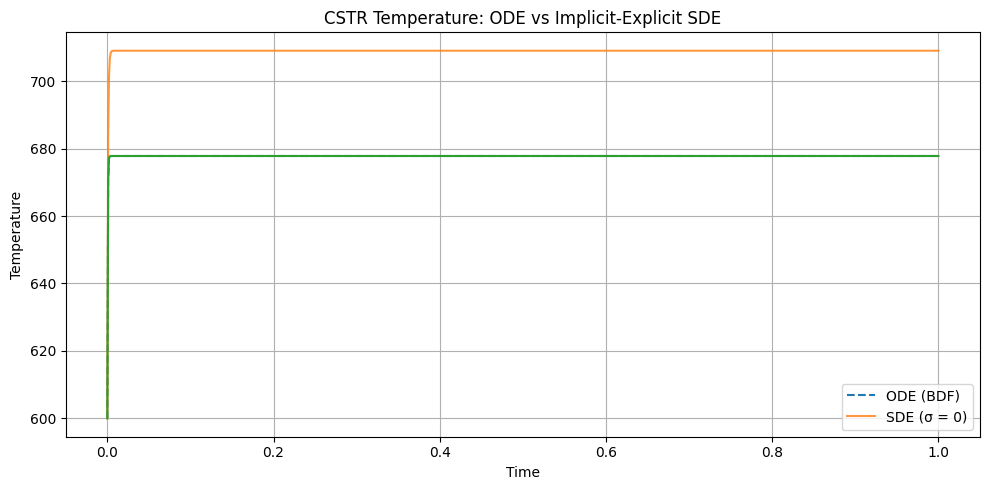

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# --- Corrected Drift and Jacobian ---
def CSTR_Fun_Jac_Corrected(t, C, Cin):
    deltaHr = -560
    rho = 1.0
    cp = 4.186
    E_adv_R = 8500
    k0 = np.exp(24.6)
    V = 0.105
    F = 250
    CA, CB, T = C
    T = np.clip(T, 300, 2000)
    k = k0 * np.exp(-E_adv_R / T)
    r = k * CA * CB
    beta = -deltaHr / (rho * cp)
    RA, RB, RT = -r, -2 * r, beta * r

    f = (Cin - C) * F / V + np.array([RA, RB, RT])

    J = np.array([
        [-F / V - k * CB,        -k * CA,           (E_adv_R / T**2) * RA],
        [-2 * k * CB,            -F / V - 2 * k * CA, (E_adv_R / T**2) * RB],
        [beta * k * CB,          beta * k * CA,     -F / V + (E_adv_R / T**2) * RT]
    ])
    return f, J

# --- Diffusion Function (temperature only) ---
def CSTR_TemperatureNoise(t, x, sigma_T):
    return np.array([0.0, 0.0, sigma_T])

# --- Newton Solver ---
def SDENewtonSolver(ffun, t, dt, psi, xinit, tol, maxit, *args):
    I = np.eye(len(xinit))
    x = xinit
    f, J = ffun(t, x, *args)
    f = np.array(f)
    R = x - f * dt - psi
    it = 1
    while np.linalg.norm(R, np.inf) > tol and it <= maxit:
        dRdx = I - np.array(J) * dt
        dx = np.linalg.solve(dRdx, R)
        x = x - dx
        f, J = ffun(t, x, *args)
        f = np.array(f)
        R = x - f * dt - psi
        it += 1
    return x

# --- Implicit-Explicit SDE Solver ---
def SDEsolverImplicitExplicit(ffun, gfun, T, x0, W, fargs=(), gargs=()):
    tol = 1e-8
    maxit = 100
    N = len(T)
    nx = len(x0)
    X = np.zeros((nx, N))
    X[:, 0] = x0
    for k in range(N - 1):
        dt = T[k + 1] - T[k]
        dW = W[:, k + 1] - W[:, k]
        g = gfun(T[k], X[:, k], *gargs)
        psi = X[:, k] + g * dW
        f, _ = ffun(T[k], X[:, k], *fargs)
        xinit = psi + f * dt
        X[:, k + 1] = SDENewtonSolver(ffun, T[k + 1], dt, psi, xinit, tol, maxit, *fargs)
    return X

# --- Standard Wiener Process ---
def StdWienerProcess(T, N, nW, Ns, seed=None):
    if seed is not None:
        np.random.seed(seed)
    dt = T / N
    dW = np.sqrt(dt) * np.random.randn(nW, N, Ns)
    W = np.concatenate((np.zeros((nW, 1, Ns)), np.cumsum(dW, axis=1)), axis=1)
    Tw = np.linspace(0, T, N + 1)
    return W, Tw, dW

# --- Simulation Parameters ---
Cin = np.array([0.8, 1.2, 600])
C0 = np.array([0.1, 0.1, 600])
tf = 1.0
N = 1000
nw = 1
sigma_T = 0.1  # Set to non-zero to test noise
seed = 42

# --- Generate Wiener Process ---
W, T, dW = StdWienerProcess(tf, N, nw, 1, seed)
W1 = W[0:1, :, 0]  # shape (1, N+1)

# --- Run SDE ---
X_sde = SDEsolverImplicitExplicit(
    CSTR_Fun_Jac_Corrected,
    CSTR_TemperatureNoise,
    T,
    C0,
    W1,
    fargs=(Cin,),
    gargs=(sigma_T,)
)

# --- Run ODE (BDF) for comparison ---
def CSTR_drift(t, C, Cin): return CSTR_Fun_Jac_Corrected(t, C, Cin)[0]
def CSTR_drift_clipped(t, C, Cin):
    f, _ = CSTR_Fun_Jac_Corrected(t, C, Cin)
    return f
def CSTR_jac(t, C, Cin):
    _, J = CSTR_Fun_Jac_Corrected(t, C, Cin)
    return J
#sol_ode = solve_ivp(CSTR_drift, (0, tf), C0, args=(Cin,), t_eval=T, method='BDF')
sol_ode_with_jac = solve_ivp(CSTR_drift, (0, tf), C0,jac = CSTR_jac, args=(Cin,), t_eval=T, method='BDF')
sol_ode = solve_ivp(CSTR_drift, (0, tf), C0,args=(Cin,), t_eval=T, method='BDF')


# --- Plot results ---
plt.figure(figsize=(10, 5))
plt.plot(T, sol_ode.y[2], label='ODE (BDF)', linestyle='--')
plt.plot(T, X_sde[2], label='SDE (σ = 0)', alpha=0.8)
plt.plot(T,sol_ode_with_jac.y[2])
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('CSTR Temperature: ODE vs Implicit-Explicit SDE')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


Make this work, why is it not running?

4. Describe your implementations and the idea you use in deriving the methods.

5. Make SDE extensions of your test problems in Problem 1

## CSTR 

In [29]:
def CSTR3_diffusion(t: float, C_states: np.ndarray, sigma: np.ndarray = np.array([0.01, 0.01, 0.05])) -> np.ndarray:
    """
    Diffusion term for the CSTR SDE model.
    Args:
        t: Time (unused here, but required for interface).
        C_states: Current state vector.
        sigma: Noise strength per variable.
    Returns:
        np.ndarray: Diffusion vector (same shape as C_states).
    """
    return sigma


In [27]:
from typing import Tuple

# constants
deltaHr = -560               # kJ/mol
rho = 1.0                    # kg/L
cp = 4.186                   # kJ/(kg*K)
Ea_over_R = 8500             # K
k0 = np.exp(24.6)            # L/(mol*s)
V = 0.105                    # L (from Wahlgreen 2020)
F = 0.1                      # L/s  (assumed constant flowrate, realistic)

# initialisations
C0 = np.array([3.4, 3.7, 200])          # Initial condition
Cin = C0 + np.array([0.03, -0.04, -10])     # Assume inlet concentration = initial for now

CSTR3_PARAMS = (deltaHr, rho, cp, Ea_over_R, k0, V, F, Cin)
CSTR3_param_type = Tuple[float, float, float, float, float, float, float, np.ndarray]

def CSTR3(t:float, C_states:np.ndarray|list|Tuple[float, float, float]=C0, params:CSTR3_param_type=CSTR3_PARAMS) -> np.ndarray:
    deltaHr, rho, cp, Ea_over_R, k0, V, F, Cin = params

    # robustness
    T = max(C_states[2], 1e-3)  # prevent underflow
    T = max(T, 1e-3)            # add temperature lower bound to avoid 0 division error

    # State variables
    CA, CB, T = C_states

    # Arrhenius law
    k = k0 * np.exp(-Ea_over_R/T)

    # Reaction model
    r = k * CA * CB
    beta = -deltaHr / (rho * cp)
    v = np.array([-1, -2, beta])  # stoichiometric vector

    # Reaction term
    R = v * r

    # CSTR dynamics
    dCdt = (Cin - C_states) * F / V + R

    return np.array(dCdt)


def CSTR3_Jac(t: float, C_states: np.ndarray|list=C0, params:CSTR3_param_type=CSTR3_PARAMS) -> np.ndarray:
    deltaHr, rho, cp, Ea_over_R, k0, V, F, Cin = params

    # State variables
    CA, CB, T = C_states

    # Safety check (avoid division by zero or overflow)
    if T < 1e-5:
        raise ValueError("Temperature too low — possible singularity in Jacobian.")

    # Arrhenius law
    k = k0 * np.exp(-Ea_over_R / T)
    r = k * CA * CB
    beta = -deltaHr / (rho * cp)

    # Derivatives
    dk_dT = (Ea_over_R / T**2) * k
    dr_dCA = k * CB
    dr_dCB = k * CA
    #dr_dT  = -Ea_over_R / T**2 * r  # product rule: d(k CA CB)/dT
    dr_dT = dk_dT * CA * CB

    # Partial derivatives of R = v * r
    v = np.array([-1, -2, beta])

    # Construct Jacobian
    J = np.empty((3, 3))

    # d(CA)/dt
    J[0, 0] = -F/V + v[0] * dr_dCA
    J[0, 1] =        v[0] * dr_dCB
    J[0, 2] =        v[0] * dr_dT

    # d(CB)/dt
    J[1, 0] =        v[1] * dr_dCA
    J[1, 1] = -F/V + v[1] * dr_dCB
    J[1, 2] =        v[1] * dr_dT

    # d(T)/dt
    J[2, 0] =        v[2] * dr_dCA
    J[2, 1] =        v[2] * dr_dCB
    J[2, 2] = -F/V + v[2] * dr_dT

    return J


def CSTR3_Fun_Jac(t:float, C_states:np.ndarray|list|Tuple[float, float, float]=C0, params:CSTR3_param_type=CSTR3_PARAMS) -> Tuple[np.ndarray, np.ndarray]:
    return CSTR3(t, C_states, params), CSTR3_Jac(t, C_states, params)

In [30]:
# --- Simulation settings ---
tf = 10.0
N = 1000
nw = 3
Ns = 1
sigma = np.array([0.01, 0.01, 0.05])  # adjust per variable if needed

# Generate Wiener process
W, T, _ = StdWienerProcess(tf, N, nw, Ns, seed=42)

# Solve the SDE (only first sample path used here)
X = SDEsolverImplicitExplicit(
    ffun=CSTR3_Fun_Jac,
    gfun=CSTR3_diffusion,
    T=T,
    x0=C0,
    W=W[:, :, 0],  # use first sample path
    fargs=(CSTR3_PARAMS,),
    gargs=(sigma,)
)


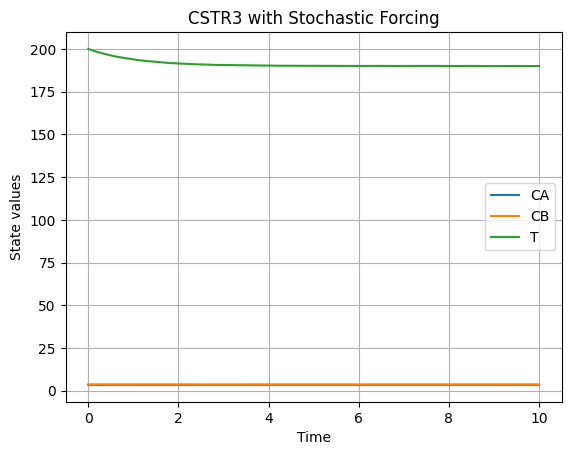

In [31]:
import matplotlib.pyplot as plt

labels = ['CA', 'CB', 'T']
for i in range(3):
    plt.plot(T, X[i], label=labels[i])
plt.xlabel('Time')
plt.ylabel('State values')
plt.legend()
plt.title('CSTR3 with Stochastic Forcing')
plt.grid(True)
plt.show()


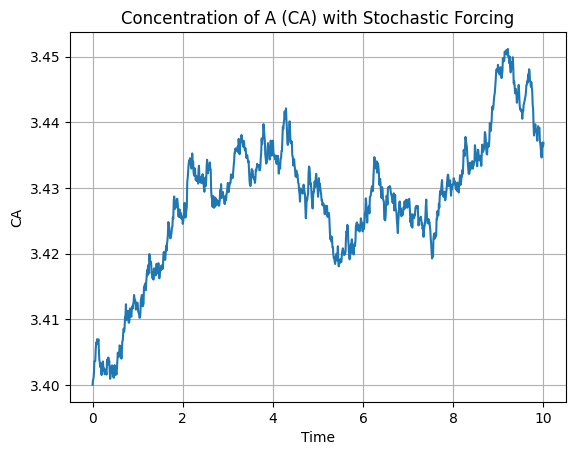

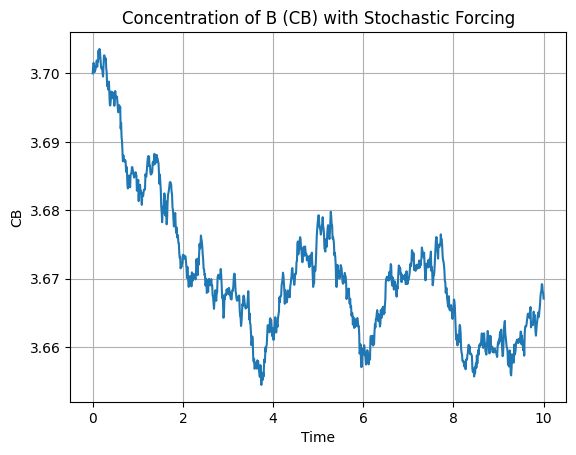

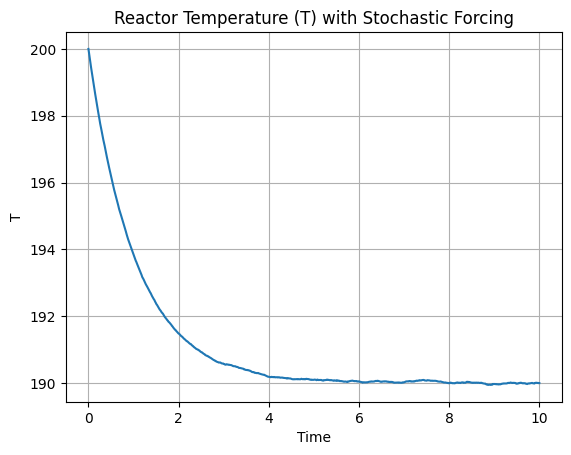

In [32]:
import matplotlib.pyplot as plt

# Plot CA
plt.figure()
plt.plot(T, X[0])
plt.xlabel('Time')
plt.ylabel('CA')
plt.title('Concentration of A (CA) with Stochastic Forcing')
plt.grid(True)

# Plot CB
plt.figure()
plt.plot(T, X[1])
plt.xlabel('Time')
plt.ylabel('CB')
plt.title('Concentration of B (CB) with Stochastic Forcing')
plt.grid(True)

# Plot T
plt.figure()
plt.plot(T, X[2])
plt.xlabel('Time')
plt.ylabel('T')
plt.title('Reactor Temperature (T) with Stochastic Forcing')
plt.grid(True)


In [37]:
# --- Implicit-Explicit solver ---
def SDEsolverImplicitExplicit(ffun, gfun, T, x0, W, fargs=(), gargs=()):
    tol = 1e-8
    maxit = 100
    N = len(T)
    nx = len(x0)
    X = np.zeros((nx, N))
    X[:, 0] = x0
    for k in range(N - 1):
        dt = T[k + 1] - T[k]
        dW = W[:, k + 1] - W[:, k]
        g = gfun(T[k], X[:, k], *gargs)
        psi = X[:, k] + g * dW
        f, _ = ffun(T[k], X[:, k], *fargs)
        xinit = psi + np.array(f) * dt
        xnew = SDENewtonSolver(ffun, T[k + 1], dt, psi, xinit, tol, maxit, *fargs)
        X[:, k + 1] = np.clip(xnew, 1e-6, 1e6)  # keep bounded
    return X


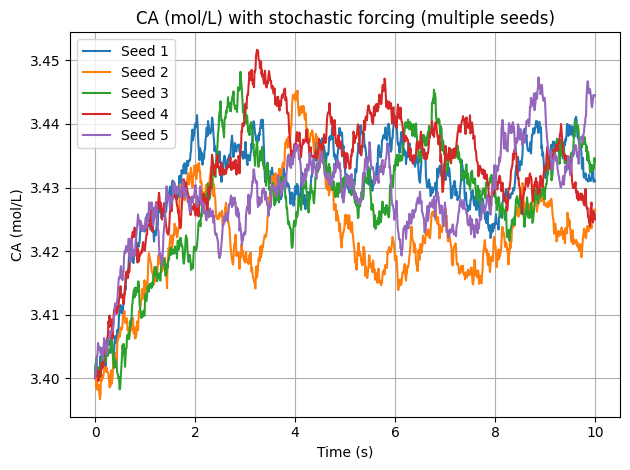

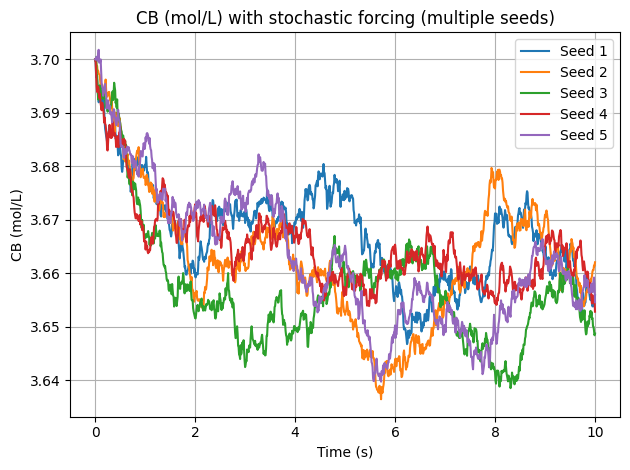

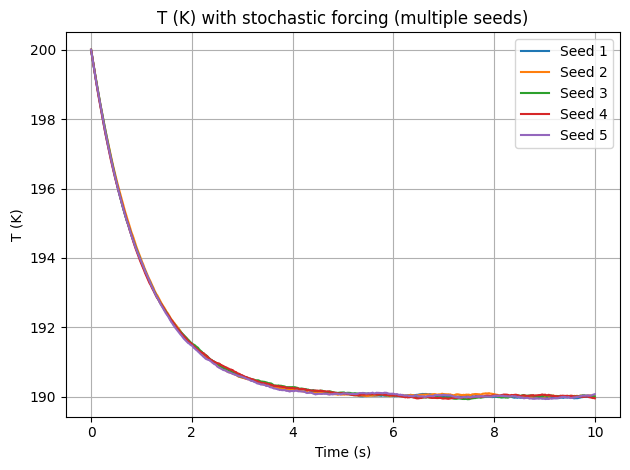

In [33]:
# Settings
sigma = np.array([0.01, 0.01, 0.05])
seeds = [1, 2, 3, 4, 5]
labels = ['CA (mol/L)', 'CB (mol/L)', 'T (K)']

# Time grid
tf = 10.0
N = 1000
nw = 3

# Store all sample paths
paths = []

for seed in seeds:
    W, T, _ = StdWienerProcess(tf, N, nw, Ns=1, seed=seed)
    X = SDEsolverImplicitExplicit(
        ffun=CSTR3_Fun_Jac,
        gfun=CSTR3_diffusion,
        T=T,
        x0=C0,
        W=W[:, :, 0],  # 1 sample path
        fargs=(CSTR3_PARAMS,),
        gargs=(sigma,)
    )
    paths.append(X)

# Plot CA, CB, and T separately
for state_idx in range(3):
    plt.figure()
    for i, X in enumerate(paths):
        plt.plot(T, X[state_idx], label=f'Seed {seeds[i]}')
    plt.xlabel('Time (s)')
    plt.ylabel(labels[state_idx])
    plt.title(f'{labels[state_idx]} with stochastic forcing (multiple seeds)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


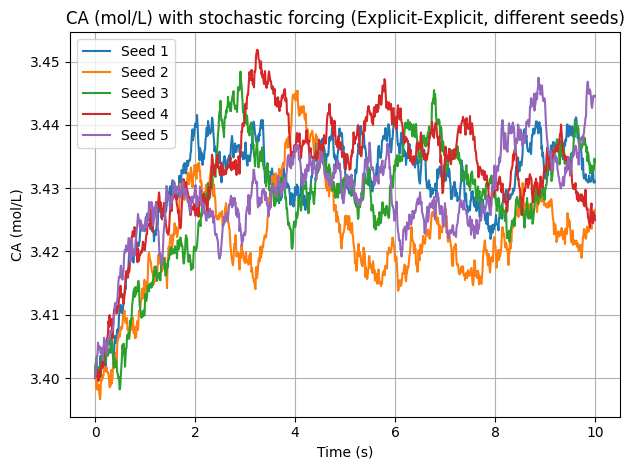

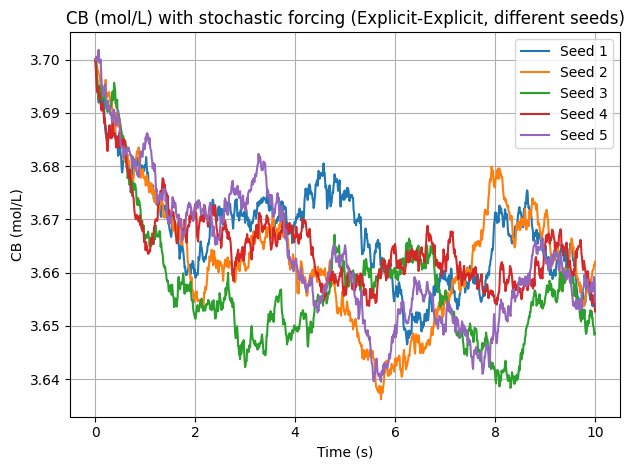

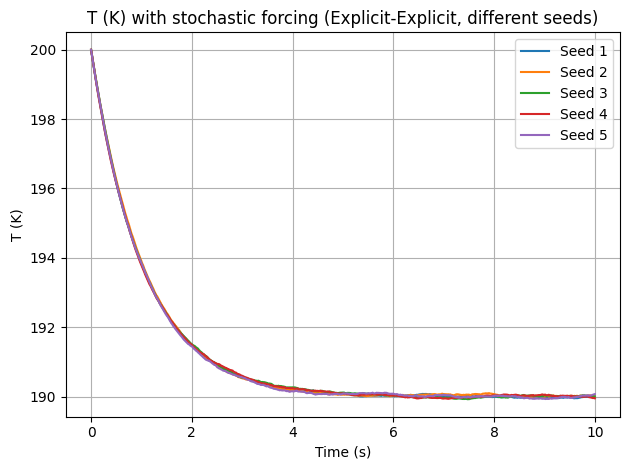

In [34]:
# Settings
sigma = np.array([0.01, 0.01, 0.05])
seeds = [1, 2, 3, 4, 5]
labels = ['CA (mol/L)', 'CB (mol/L)', 'T (K)']

# Time grid
tf = 10.0
N = 1000
nw = 3

# Store all sample paths
paths = []

for seed in seeds:
    W, T, _ = StdWienerProcess(tf, N, nw, Ns=1, seed=seed)
    X = SDEsolverExplicitExplicit(
        ffun=CSTR3_Fun_Jac,
        gfun=CSTR3_diffusion,
        T=T,
        x0=C0,
        W=W[:, :, 0],  # 1 sample path
        fargs=(CSTR3_PARAMS,),
        gargs=(sigma,)
    )
    paths.append(X)

# Plot CA, CB, and T separately
for state_idx in range(3):
    plt.figure()
    for i, X in enumerate(paths):
        plt.plot(T, X[state_idx], label=f'Seed {seeds[i]}')
    plt.xlabel('Time (s)')
    plt.ylabel(labels[state_idx])
    plt.title(f'{labels[state_idx]} with stochastic forcing (Explicit-Explicit, different seeds)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


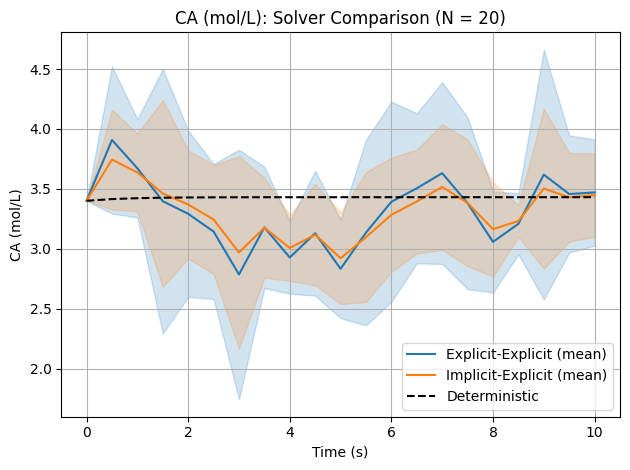

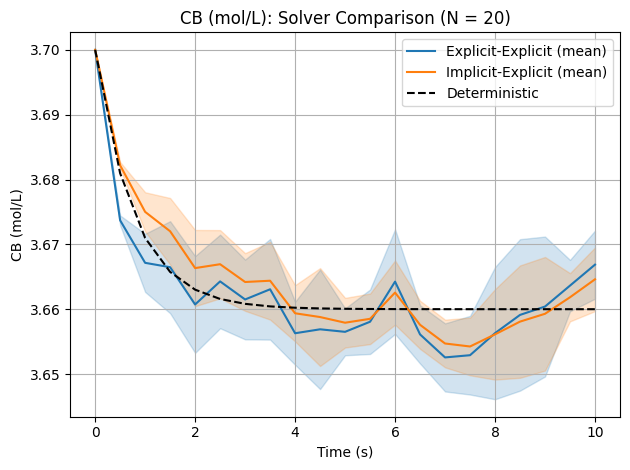

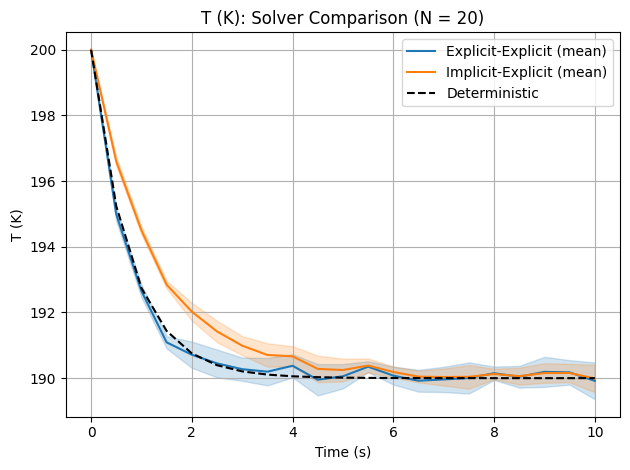

In [46]:
# Simulation settings
tf = 10.0
N = 20
T = np.linspace(0, tf, N + 1)
nw = 3
seeds = [1, 2, 3, 4, 5]
sigma = np.array([1, 0.01, 0.5])
labels = ['CA (mol/L)', 'CB (mol/L)', 'T (K)']

# Preallocate arrays to collect results
paths_expl = []  # explicit-explicit
paths_impl = []  # implicit-explicit

# Simulate both solvers for each seed
for seed in seeds:
    W, _, _ = StdWienerProcess(tf, N, nw, Ns=1, seed=seed)
    W_single = W[:, :, 0]

    # Explicit-Explicit
    X_exp = SDEsolverExplicitExplicit(
        ffun=CSTR3_Fun_Jac,
        gfun=CSTR3_diffusion,
        T=T,
        x0=C0,
        W=W_single,
        fargs=(CSTR3_PARAMS,),
        gargs=(sigma,)
    )
    paths_expl.append(X_exp)

    # Implicit-Explicit
    X_imp = SDEsolverImplicitExplicit(
        ffun=CSTR3_Fun_Jac,
        gfun=CSTR3_diffusion,
        T=T,
        x0=C0,
        W=W_single,
        fargs=(CSTR3_PARAMS,),
        gargs=(sigma,)
    )
    paths_impl.append(X_imp)

# Deterministic solution (no noise)
X_det = np.zeros((3, N+1))
X_det[:, 0] = C0
for k in range(N):
    dt = T[k + 1] - T[k]
    f, _ = CSTR3_Fun_Jac(T[k], X_det[:, k], CSTR3_PARAMS)
    X_det[:, k+1] = X_det[:, k] + np.array(f) * dt

# Convert to arrays for mean/std computation
expl = np.stack(paths_expl)  # shape (num_paths, 3, N+1)
impl = np.stack(paths_impl)

# Plot: one per state
for i in range(3):
    plt.figure()
    # Mean ± std bands
    mean_expl = expl[:, i, :].mean(axis=0)
    std_expl = expl[:, i, :].std(axis=0)
    mean_impl = impl[:, i, :].mean(axis=0)
    std_impl = impl[:, i, :].std(axis=0)

    plt.plot(T, mean_expl, label='Explicit-Explicit (mean)', color='tab:blue')
    plt.fill_between(T, mean_expl - std_expl, mean_expl + std_expl, color='tab:blue', alpha=0.2)

    plt.plot(T, mean_impl, label='Implicit-Explicit (mean)', color='tab:orange')
    plt.fill_between(T, mean_impl - std_impl, mean_impl + std_impl, color='tab:orange', alpha=0.2)

    plt.plot(T, X_det[i], label='Deterministic', color='black', linestyle='--')

    plt.xlabel("Time (s)")
    plt.ylabel(labels[i])
    plt.title(f'{labels[i]}: Solver Comparison (N = {N})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


CSTR- 1

In [ ]:
# constants; same as CSTR3 plus... [Wahlgreen et al. (2020)]
CA_in = 1.6/2                # mol/L
CB_in = 2.4/2                # mol/L

# initial conditions
T0 = 273.15                 # initial reactor temperature
Tin = 273.15                # inlet feed temperature

CSTR1_PARAMS = (deltaHr, rho, cp, Ea_over_R, k0, V, F, CA_in, CB_in, T0, Tin)
CSTR1_param_type = Tuple[float, float, float, float, float, float, float, float, float, float, float]

def CSTR1(t:float, T_state:float, params:CSTR1_param_type=CSTR1_PARAMS) -> float:
    if type(T_state)==list: 
        T_state = T_state[0]
    deltaHr, rho, cp, Ea_over_R, k0, V, F, CA_in, CB_in, T0, Tin = params
    beta = -deltaHr / (rho * cp)

    CA = CA_in + 1/beta * (T0-T_state)
    CB = CB_in + 2/beta * (T0-T_state)

    k = k0 * np.exp(-Ea_over_R/T_state)
    r = k * CA * CB

    dTdt = (Tin - T_state) * F/V + beta * r

    return dTdt

def CSTR1_Jac(t:float, T_state:float, params:CSTR1_param_type=CSTR1_PARAMS) -> np.ndarray:
    deltaHr, rho, cp, Ea_over_R, k0, V, F, CA_in, CB_in, T0, Tin = params
    beta = -deltaHr / (rho * cp)

    CA = CA_in + (1/beta)*(T0 - T_state)
    CB = CB_in + (2/beta)*(T0 - T_state)

    k = k0 * np.exp(-Ea_over_R / T_state)
    r = k * CA * CB    

    # Derivatives
    dk_dT = (Ea_over_R / T_state**2) * k
    dCA_dT = -1/beta
    dCB_dT = -2/beta

    # Full derivative using product rule
    dr_dT = dk_dT * CA * CB + k * dCA_dT * CB + k * CA * dCB_dT

    # return Jacobian, bc 1D simply derivative
    return np.array([-F/V + beta * dr_dT])

def CSTR1_Fun_Jac(t:float, T_state:float, params:CSTR1_param_type=CSTR1_PARAMS) -> Tuple[float, np.ndarray]:
    return CSTR1(t, T_state, params), CSTR1_Jac(t, T_state, params)



In [47]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple

# --- CSTR1 Parameters ---
deltaHr = -560
rho = 1.0
cp = 4.186
Ea_over_R = 8500
k0 = np.exp(24.6)
V = 0.105
F = 0.1
CA_in = 1.6 / 2
CB_in = 2.4 / 2
T0 = 273.15
Tin = 273.15

CSTR1_PARAMS = (deltaHr, rho, cp, Ea_over_R, k0, V, F, CA_in, CB_in, T0, Tin)

# --- CSTR1 Model ---
def CSTR1(t: float, T_state: float, params=CSTR1_PARAMS) -> float:
    if isinstance(T_state, list) or isinstance(T_state, np.ndarray):
        T_state = T_state[0]
    deltaHr, rho, cp, Ea_over_R, k0, V, F, CA_in, CB_in, T0, Tin = params
    beta = -deltaHr / (rho * cp)
    CA = CA_in + (1 / beta) * (T0 - T_state)
    CB = CB_in + (2 / beta) * (T0 - T_state)
    k = k0 * np.exp(-Ea_over_R / T_state)
    r = k * CA * CB
    dTdt = (Tin - T_state) * F / V + beta * r
    return dTdt

def CSTR1_Jac(t: float, T_state: float, params=CSTR1_PARAMS) -> np.ndarray:
    deltaHr, rho, cp, Ea_over_R, k0, V, F, CA_in, CB_in, T0, Tin = params
    beta = -deltaHr / (rho * cp)
    CA = CA_in + (1 / beta) * (T0 - T_state)
    CB = CB_in + (2 / beta) * (T0 - T_state)
    k = k0 * np.exp(-Ea_over_R / T_state)
    r = k * CA * CB
    dk_dT = (Ea_over_R / T_state**2) * k
    dCA_dT = -1 / beta
    dCB_dT = -2 / beta
    dr_dT = dk_dT * CA * CB + k * dCA_dT * CB + k * CA * dCB_dT
    return np.array([-F / V + beta * dr_dT])

def CSTR1_Fun_Jac(t: float, T_state: float, params=CSTR1_PARAMS) -> Tuple[float, np.ndarray]:
    return CSTR1(t, T_state, params), CSTR1_Jac(t, T_state, params)

# --- Diffusion term (scalar) ---
def CSTR1_diffusion(t: float, T_state: float, sigma: float = 0.5) -> float:
    return sigma

# --- StdWienerProcess (1D) ---
def StdWienerProcess(tf, N, nw, Ns, seed=0):
    np.random.seed(seed)
    dt = tf / N
    T = np.linspace(0, tf, N + 1)
    dW = np.random.normal(0.0, np.sqrt(dt), size=(nw, N, Ns))
    W = np.zeros((nw, N + 1, Ns))
    W[:, 1:, :] = np.cumsum(dW, axis=1)
    return W, T, dW

# --- Newton Solver ---
def SDENewtonSolver(ffun, t, dt, psi, xinit, tol, maxit, *args):
    x = xinit
    f, J = ffun(t, x, *args)
    R = x - f * dt - psi
    it = 1
    while np.linalg.norm(R, np.inf) > tol and it <= maxit:
        dRdx = 1 - J[0] * dt
        dx = R / dRdx
        x -= dx
        f, J = ffun(t, x, *args)
        R = x - f * dt - psi
        it += 1
    return x

# --- Implicit-Explicit solver ---
def SDEsolverImplicitExplicit(ffun, gfun, T, x0, W, fargs=(), gargs=()):
    tol = 1e-8
    maxit = 100
    N = len(T)
    X = np.zeros(N)
    X[0] = x0
    for k in range(N - 1):
        dt = T[k + 1] - T[k]
        dW = W[0, k + 1] - W[0, k]
        g = gfun(T[k], X[k], *gargs)
        psi = X[k] + g * dW
        f, _ = ffun(T[k], X[k], *fargs)
        xinit = psi + f * dt
        xnew = SDENewtonSolver(ffun, T[k + 1], dt, psi, xinit, tol, maxit, *fargs)
        X[k + 1] = np.clip(xnew, 1e-6, 1e6)
    return X

# --- Explicit-Explicit solver ---
def SDEsolverExplicitExplicit(ffun, gfun, T, x0, W, fargs=(), gargs=()):
    N = len(T)
    X = np.zeros(N)
    X[0] = x0
    for k in range(N - 1):
        dt = T[k + 1] - T[k]
        dW = W[0, k + 1] - W[0, k]
        f, _ = ffun(T[k], X[k], *fargs)
        g = gfun(T[k], X[k], *gargs)
        X[k + 1] = X[k] + f * dt + g * dW
        X[k + 1] = np.clip(X[k + 1], 1e-6, 1e6)
    return X

# --- Simulation ---
tf = 10.0
N = 20
T = np.linspace(0, tf, N + 1)
sigma = 0.5
seeds = [1, 2, 3, 4, 5]

expl_paths = []
impl_paths = []

for seed in seeds:
    W, _, _ = StdWienerProcess(tf, N, 1, 1, seed=seed)
    W = W[:, :, 0]

    X_exp = SDEsolverExplicitExplicit(CSTR1_Fun_Jac, CSTR1_diffusion, T, T0, W,
                                      fargs=(CSTR1_PARAMS,), gargs=(sigma,))
    X_imp = SDEsolverImplicitExplicit(CSTR1_Fun_Jac, CSTR1_diffusion, T, T0, W,
                                      fargs=(CSTR1_PARAMS,), gargs=(sigma,))
    expl_paths.append(X_exp)
    impl_paths.append(X_imp)

# Deterministic
X_det = np.zeros(N + 1)
X_det[0] = T0
for k in range(N):
    dt = T[k + 1] - T[k]
    f, _ = CSTR1_Fun_Jac(T[k], X_det[k], CSTR1_PARAMS)
    X_det[k + 1] = X_det[k] + f * dt

# Convert to arrays
expl = np.stack(expl_paths)
impl = np.stack(impl_paths)

# Plot
plt.figure()
mean_expl = expl.mean(axis=0)
std_expl = expl.std(axis=0)
mean_impl = impl.mean(axis=0)
std_impl = impl.std(axis=0)

plt.plot(T, mean_expl, label='Explicit-Explicit (mean)', color='tab:blue')
plt.fill_between(T, mean_expl - std_expl, mean_expl + std_expl, color='tab:blue', alpha=0.2)

plt.plot(T, mean_impl, label='Implicit-Explicit (mean)', color='tab:orange')
plt.fill_between(T, mean_impl - std_impl, mean_impl + std_impl, color='tab:orange', alpha=0.2)

plt.plot(T, X_det, label='Deterministic', color='black', linestyle='--')

plt.xlabel("Time (s)")
plt.ylabel("Temperature (K)")
plt.title(f'CSTR1 Temperature: Solver Comparison (N = {N})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


ValueError: Improper number of dimensions to norm.

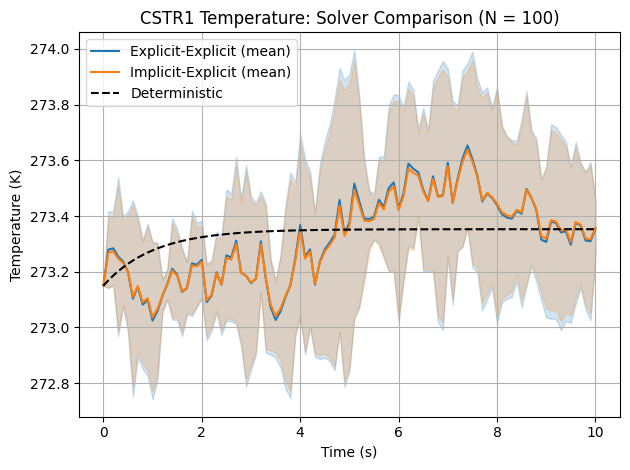

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple

# --- CSTR1 Parameters ---
deltaHr = -560
rho = 1.0
cp = 4.186
Ea_over_R = 8500
k0 = np.exp(24.6)
V = 0.105
F = 0.1
CA_in = 1.6 / 2
CB_in = 2.4 / 2
T0 = 273.15
Tin = 273.15

CSTR1_PARAMS = (deltaHr, rho, cp, Ea_over_R, k0, V, F, CA_in, CB_in, T0, Tin)

# --- CSTR1 Model ---
def CSTR1(t: float, T_state: float, params=CSTR1_PARAMS) -> float:
    if isinstance(T_state, (list, np.ndarray)):
        T_state = T_state[0]
    deltaHr, rho, cp, Ea_over_R, k0, V, F, CA_in, CB_in, T0, Tin = params
    beta = -deltaHr / (rho * cp)
    CA = CA_in + (1 / beta) * (T0 - T_state)
    CB = CB_in + (2 / beta) * (T0 - T_state)
    k = k0 * np.exp(-Ea_over_R / T_state)
    r = k * CA * CB
    dTdt = (Tin - T_state) * F / V + beta * r
    return dTdt

def CSTR1_Jac(t: float, T_state: float, params=CSTR1_PARAMS) -> np.ndarray:
    deltaHr, rho, cp, Ea_over_R, k0, V, F, CA_in, CB_in, T0, Tin = params
    beta = -deltaHr / (rho * cp)
    CA = CA_in + (1 / beta) * (T0 - T_state)
    CB = CB_in + (2 / beta) * (T0 - T_state)
    k = k0 * np.exp(-Ea_over_R / T_state)
    r = k * CA * CB
    dk_dT = (Ea_over_R / T_state**2) * k
    dCA_dT = -1 / beta
    dCB_dT = -2 / beta
    dr_dT = dk_dT * CA * CB + k * dCA_dT * CB + k * CA * dCB_dT
    return np.array([-F / V + beta * dr_dT])

def CSTR1_Fun_Jac(t: float, T_state: float, params=CSTR1_PARAMS) -> Tuple[float, np.ndarray]:
    return CSTR1(t, T_state, params), CSTR1_Jac(t, T_state, params)

# --- Diffusion term ---
def CSTR1_diffusion(t: float, T_state: float, sigma: float = 0.5) -> float:
    return sigma

# --- Wiener Process Generator ---
def StdWienerProcess(tf, N, nw, Ns, seed=0):
    np.random.seed(seed)
    dt = tf / N
    T = np.linspace(0, tf, N + 1)
    dW = np.random.normal(0.0, np.sqrt(dt), size=(nw, N, Ns))
    W = np.zeros((nw, N + 1, Ns))
    W[:, 1:, :] = np.cumsum(dW, axis=1)
    return W, T, dW

# --- Newton Solver (fixed) ---
def SDENewtonSolver(ffun, t, dt, psi, xinit, tol, maxit, *args):
    x = xinit
    f, J = ffun(t, x, *args)
    R = x - f * dt - psi
    it = 1
    while abs(R) > tol and it <= maxit:
        dRdx = 1 - J[0] * dt
        dx = R / dRdx
        x -= dx
        f, J = ffun(t, x, *args)
        R = x - f * dt - psi
        it += 1
    return x

# --- Implicit-Explicit SDE Solver ---
def SDEsolverImplicitExplicit(ffun, gfun, T, x0, W, fargs=(), gargs=()):
    tol = 1e-8
    maxit = 100
    N = len(T)
    X = np.zeros(N)
    X[0] = x0
    for k in range(N - 1):
        dt = T[k + 1] - T[k]
        dW = W[0, k + 1] - W[0, k]
        g = gfun(T[k], X[k], *gargs)
        psi = X[k] + g * dW
        f, _ = ffun(T[k], X[k], *fargs)
        xinit = psi + f * dt
        xnew = SDENewtonSolver(ffun, T[k + 1], dt, psi, xinit, tol, maxit, *fargs)
        X[k + 1] = np.clip(xnew, 1e-6, 1e6)
    return X

# --- Explicit-Explicit SDE Solver ---
def SDEsolverExplicitExplicit(ffun, gfun, T, x0, W, fargs=(), gargs=()):
    N = len(T)
    X = np.zeros(N)
    X[0] = x0
    for k in range(N - 1):
        dt = T[k + 1] - T[k]
        dW = W[0, k + 1] - W[0, k]
        f, _ = ffun(T[k], X[k], *fargs)
        g = gfun(T[k], X[k], *gargs)
        X[k + 1] = X[k] + f * dt + g * dW
        X[k + 1] = np.clip(X[k + 1], 1e-6, 1e6)
    return X

# --- Simulation Parameters ---
tf = 10.0
N = 100
T = np.linspace(0, tf, N + 1)
sigma = 0.5
seeds = [1, 2, 3, 4, 5]

# --- Run Simulations ---
expl_paths = []
impl_paths = []

for seed in seeds:
    W, _, _ = StdWienerProcess(tf, N, 1, 1, seed=seed)
    W = W[:, :, 0]

    X_exp = SDEsolverExplicitExplicit(CSTR1_Fun_Jac, CSTR1_diffusion, T, T0, W,
                                      fargs=(CSTR1_PARAMS,), gargs=(sigma,))
    X_imp = SDEsolverImplicitExplicit(CSTR1_Fun_Jac, CSTR1_diffusion, T, T0, W,
                                      fargs=(CSTR1_PARAMS,), gargs=(sigma,))
    expl_paths.append(X_exp)
    impl_paths.append(X_imp)

# --- Deterministic Solution ---
X_det = np.zeros(N + 1)
X_det[0] = T0
for k in range(N):
    dt = T[k + 1] - T[k]
    f, _ = CSTR1_Fun_Jac(T[k], X_det[k], CSTR1_PARAMS)
    X_det[k + 1] = X_det[k] + f * dt

# --- Plot Results ---
expl = np.stack(expl_paths)
impl = np.stack(impl_paths)

plt.figure()
mean_expl = expl.mean(axis=0)
std_expl = expl.std(axis=0)
mean_impl = impl.mean(axis=0)
std_impl = impl.std(axis=0)

plt.plot(T, mean_expl, label='Explicit-Explicit (mean)', color='tab:blue')
plt.fill_between(T, mean_expl - std_expl, mean_expl + std_expl, color='tab:blue', alpha=0.2)

plt.plot(T, mean_impl, label='Implicit-Explicit (mean)', color='tab:orange')
plt.fill_between(T, mean_impl - std_impl, mean_impl + std_impl, color='tab:orange', alpha=0.2)

plt.plot(T, X_det, label='Deterministic', color='black', linestyle='--')

plt.xlabel("Time (s)")
plt.ylabel("Temperature (K)")
plt.title(f'CSTR1 Temperature: Solver Comparison (N = {N})')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Next lets try the fucking PFR 3 state


In [51]:
def PFR_3state(t, C, Cin, p):
    # Storing inlet concentration/temperature
    CAin, CBin, Tin = Cin
    n = p['Nz']
    dz = p['dz']
    v = p['v']
    F = p['F']
    A = 0.1
    vol= F/A

    # Hardcoding variables
    k0 = np.exp(24.6) 
    DA = 0.1
    DB = 0.1
    DT = 0.1

    # Extracting initial values
    CA = C[0:n]
    CB = C[n:2*n]
    T = C[2*n:3*n]
                 
    Ea_over_R = 8500             
    
    k = k0 * np.exp(-Ea_over_R / T)
    r = k * CA * CB
    
    # Convection at finite volume interfaces
    NconvA = np.zeros(n+1)
    NconvA[0] = vol * CAin
    NconvA[1:n+1] = vol * CA[0:n]
    
    NconvB = np.zeros(n+1)
    NconvB[0] = vol * CBin
    NconvB[1:n+1] = vol * CB[0:n]

    NconvT = np.zeros(n+1)
    NconvT[0] = vol * Tin
    NconvT[1:n+1] = vol * T[0:n]
    
    # Diffusion at finite volume interfaces
    JA = np.zeros(n+1) # no diffusion at inlet or outlet
    JA[1:n] = (-DA/dz) * (CA[1:n] - CA[0:n-1])

    JB = np.zeros(n+1)
    JB[1:n] = (-DB/dz) * (CB[1:n] - CB[0:n-1])

    JT = np.zeros(n+1)
    JT[1:n] = (-DT/dz) * (T[1:n] - T[0:n-1])
    
    # Flux = convection + diffusion
    NA = NconvA + JA
    NB = NconvB + JB
    NT = NconvT + JT
    
    # Reaction and production rates in finite volumes
    r = k * CA * CB
    RA = v[0] * r
    RB = v[1] * r
    RT = v[2] * r
    
    # Differential Equations (mass balances at finite volumes)
    CAdot = (NA[1:n+1] - NA[0:n])/(-dz) + RA
    CBdot = (NB[1:n+1] - NB[0:n])/(-dz) + RB
    Tdot = (NT[1:n+1] - NT[0:n])/(-dz) + RT
    
    return np.vstack([CAdot, CBdot, Tdot]).flatten()

In [52]:
# Discretization parameters
Nz = 100
L = 10

# reaction velocity
deltaHr = -560               
rho = 1.0                   
cp = 4.186  
beta = -deltaHr / (rho * cp)   
v = np.array([-1, -2, beta])
F = 50

# Derived Parameters
deltaz = L / Nz

# Pack parameters into a dictionary
p = {
    'Nz': Nz,
    'dz': deltaz,
    'v': v,
    'F': F
}

# Initial conditions
CA0 = np.full(Nz, 0.1)
CB0 = np.full(Nz, 0.1)
T0 = np.full(Nz, 200)
C0 = np.concatenate([CA0, CB0, T0])

# Given inlet concentration and temperature
Cin = np.array([1.6, 2.4, 350])

# Timespan and discretization
t_span = (0, 0.03)
t_eval = np.linspace(t_span[0], t_span[1], 1000)

sol = solve_ivp(PFR_3state, t_span, C0, args=(Cin,p,), t_eval=t_eval, method='BDF')#, jac=PFR_3state_Jac)


# Plotting CA, CB, T at different times
fig, axs = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

times_to_plot = np.linspace(0, t_span[1], 5)
indices = [np.argmin(np.abs(sol.t - t)) for t in times_to_plot]
z = np.linspace(0, L, Nz)

for i in indices:
    CA_i = sol.y[0:Nz, i]
    CB_i = sol.y[Nz:2*Nz, i]
    T_i = sol.y[2*Nz:3*Nz, i]

    axs[0].plot(z, CA_i, label=f't={sol.t[i]:.2f}s')
    axs[1].plot(z, CB_i, label=f't={sol.t[i]:.2f}s')
    axs[2].plot(z, T_i, label=f't={sol.t[i]:.2f}s')

axs[0].set_ylabel('CA')
axs[1].set_ylabel('CB')
axs[2].set_ylabel('T (K)')
axs[2].set_xlabel('Reactor Length (z)')

for ax in axs:
    ax.legend()
    ax.grid(True)

fig.suptitle('Concentration and Temperature Profiles Over Reactor Length')
plt.tight_layout()
plt.show()

NameError: name 'solve_ivp' is not defined

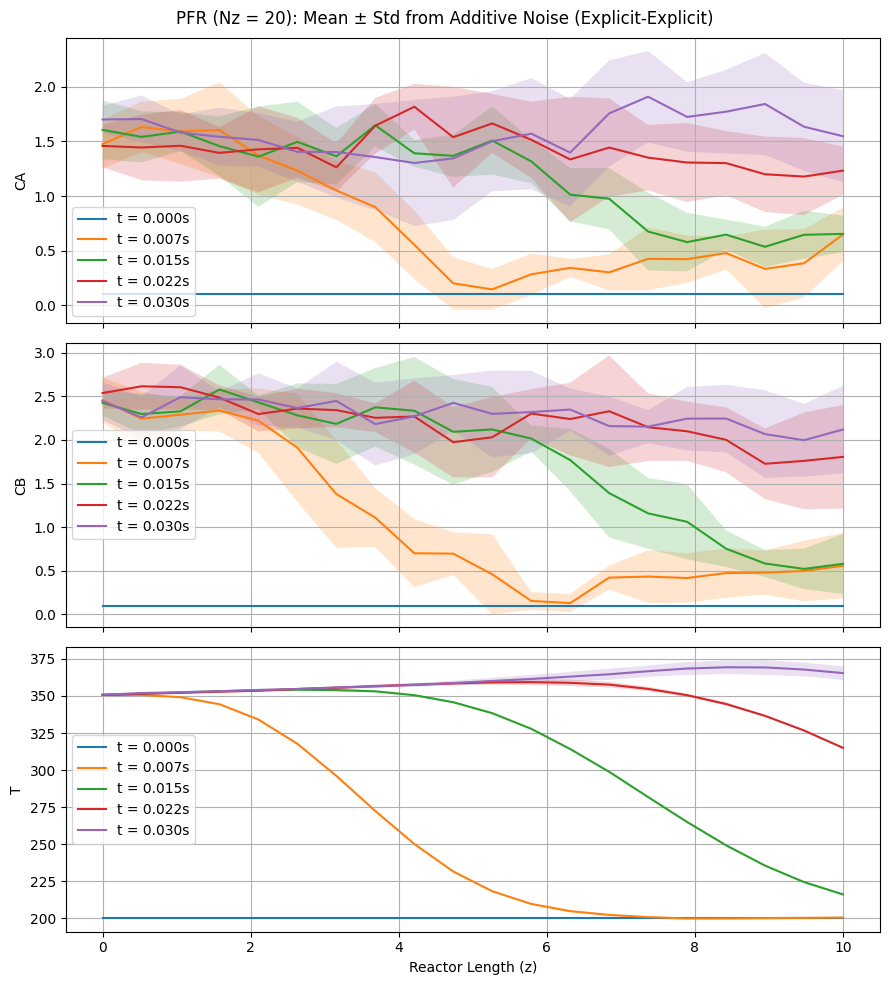

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# --- PFR model setup (Nz = 20, additive noise on all states) ---
def PFR_3state(t, C, Cin, p):
    CAin, CBin, Tin = Cin
    n = p['Nz']
    dz = p['dz']
    v = p['v']
    F = p['F']
    A = 0.1
    vol = F / A

    # Constants
    k0 = np.exp(24.6)
    DA = DB = DT = 0.1
    Ea_over_R = 8500

    CA = C[0:n]
    CB = C[n:2*n]
    T = C[2*n:3*n]

    k = k0 * np.exp(-Ea_over_R / T)
    r = k * CA * CB

    # Convection
    NconvA = np.zeros(n+1); NconvA[0] = vol * CAin; NconvA[1:] = vol * CA
    NconvB = np.zeros(n+1); NconvB[0] = vol * CBin; NconvB[1:] = vol * CB
    NconvT = np.zeros(n+1); NconvT[0] = vol * Tin;  NconvT[1:] = vol * T

    # Diffusion
    JA = np.zeros(n+1); JA[1:n] = (-DA/dz) * (CA[1:] - CA[:-1])
    JB = np.zeros(n+1); JB[1:n] = (-DB/dz) * (CB[1:] - CB[:-1])
    JT = np.zeros(n+1); JT[1:n] = (-DT/dz) * (T[1:] - T[:-1])

    NA = NconvA + JA
    NB = NconvB + JB
    NT = NconvT + JT

    RA = v[0] * r
    RB = v[1] * r
    RT = v[2] * r

    CAdot = (NA[1:] - NA[:-1]) / (-dz) + RA
    CBdot = (NB[1:] - NB[:-1]) / (-dz) + RB
    Tdot  = (NT[1:] - NT[:-1]) / (-dz) + RT

    return np.concatenate([CAdot, CBdot, Tdot])

# --- Wiener process generator ---
def StdWienerProcess(tf, N, nw, Ns, seed=0):
    np.random.seed(seed)
    dt = tf / N
    T = np.linspace(0, tf, N + 1)
    dW = np.random.normal(0.0, np.sqrt(dt), size=(nw, N, Ns))
    W = np.zeros((nw, N + 1, Ns))
    W[:, 1:, :] = np.cumsum(dW, axis=1)
    return W, T, dW

# --- SDE solver: Explicit-Explicit ---
def SDEsolverExplicitExplicit(ffun, gfun, T, x0, W, fargs=(), gargs=()):
    N = len(T)
    nx = len(x0)
    X = np.zeros((nx, N))
    X[:, 0] = x0
    for k in range(N - 1):
        dt = T[k + 1] - T[k]
        dW = W[:, k + 1] - W[:, k]
        f = ffun(T[k], X[:, k], *fargs)
        g = gfun(T[k], X[:, k], *gargs)
        X[:, k + 1] = X[:, k] + f * dt + g * dW
        X[:, k + 1] = np.clip(X[:, k + 1], 1e-6, 1e6)
    return X

# --- Additive diffusion function ---
def PFR_additive_diffusion(t, C, sigma):
    return np.full_like(C, sigma)

# --- Problem setup ---
Nz = 20
L = 10
deltaHr = -560
rho = 1.0
cp = 4.186
beta = -deltaHr / (rho * cp)
v = np.array([-1, -2, beta])
F = 50
dz = L / Nz

p = {'Nz': Nz, 'dz': dz, 'v': v, 'F': F}
CA0 = np.full(Nz, 0.1)
CB0 = np.full(Nz, 0.1)
T0 = np.full(Nz, 200)
C0 = np.concatenate([CA0, CB0, T0])
Cin = np.array([1.6, 2.4, 350])

# Time setup
tf = 0.03
N = 200
sigma = 10
seeds = [1, 2, 3, 4, 5]
W, T, _ = StdWienerProcess(tf, N, 3*Nz, Ns=len(seeds), seed=0)

# Run stochastic simulations
stochastic_paths = []
for i, seed in enumerate(seeds):
    Xi = SDEsolverExplicitExplicit(
        PFR_3state,
        PFR_additive_diffusion,
        T,
        C0,
        W[:, :, i],
        fargs=(Cin, p),
        gargs=(sigma,)
    )
    stochastic_paths.append(Xi)

# Deterministic solution
def rhs(t, y): return PFR_3state(t, y, Cin, p)
sol_det = solve_ivp(rhs, (0, tf), C0, t_eval=T, method='BDF')

# Package result for plotting
stochastic_paths = np.stack(stochastic_paths)  # shape (n_paths, n_states, N+1)
mean_path = np.mean(stochastic_paths, axis=0)
std_path = np.std(stochastic_paths, axis=0)

# Plot spatial profiles at selected times
import matplotlib.pyplot as plt

z = np.linspace(0, L, Nz)
time_indices = np.linspace(0, N, 5, dtype=int)
state_labels = ['CA', 'CB', 'T']

fig, axs = plt.subplots(3, 1, figsize=(9, 10), sharex=True)

for i, ax in enumerate(axs):
    for idx in time_indices:
        CA = mean_path[0:Nz, idx]
        CB = mean_path[Nz:2*Nz, idx]
        T_ = mean_path[2*Nz:, idx]
        std_CA = std_path[0:Nz, idx]
        std_CB = std_path[Nz:2*Nz, idx]
        std_T  = std_path[2*Nz:, idx]

        ax_idx = [CA, CB, T_][i]
        std_idx = [std_CA, std_CB, std_T][i]

        ax.plot(z, ax_idx, label=f't = {T[idx]:.3f}s')
        ax.fill_between(z, ax_idx - std_idx, ax_idx + std_idx, alpha=0.2)

    ax.set_ylabel(state_labels[i])
    ax.grid(True)
    ax.legend()

axs[2].set_xlabel('Reactor Length (z)')
fig.suptitle('PFR (Nz = 20): Mean ± Std from Additive Noise (Explicit-Explicit)')
plt.tight_layout()
plt.show()


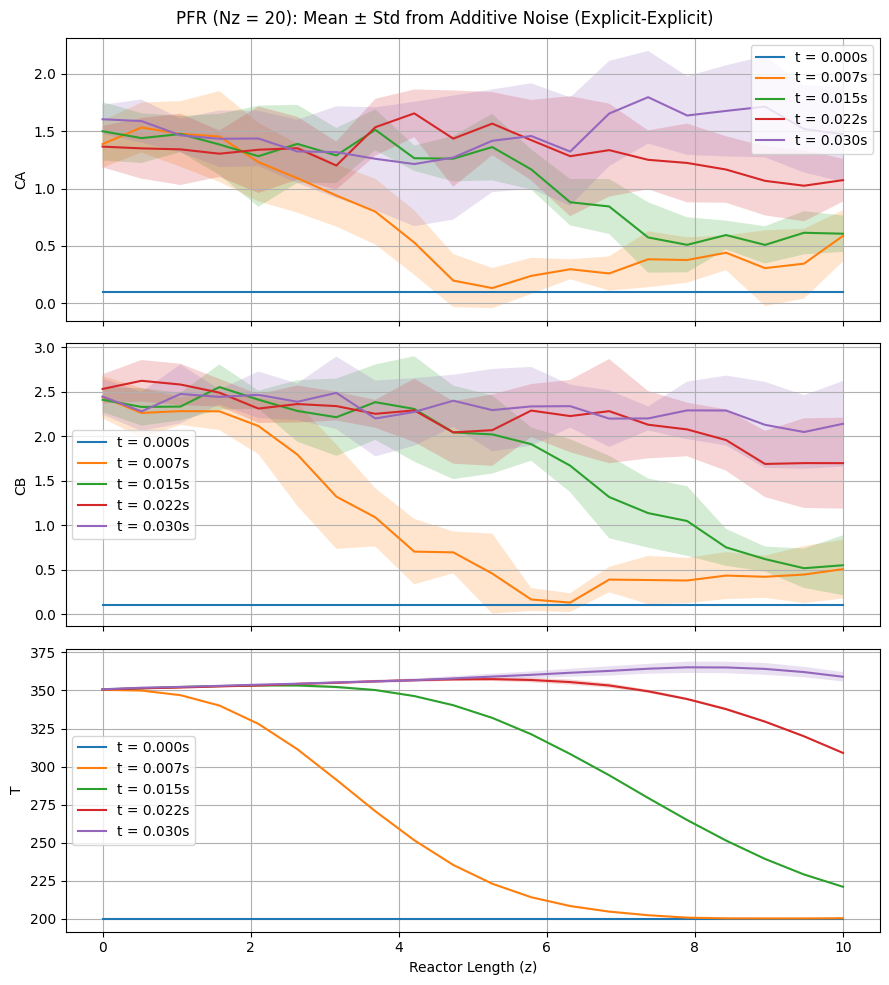

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# --- PFR model setup (Nz = 20, additive noise on all states) ---
def PFR_3state(t, C, Cin, p):
    CAin, CBin, Tin = Cin
    n = p['Nz']
    dz = p['dz']
    v = p['v']
    F = p['F']
    A = 0.1
    vol = F / A

    # Constants
    k0 = np.exp(24.6)
    DA = DB = DT = 0.1
    Ea_over_R = 8500

    CA = C[0:n]
    CB = C[n:2*n]
    T = C[2*n:3*n]

    k = k0 * np.exp(-Ea_over_R / T)
    r = k * CA * CB

    # Convection
    NconvA = np.zeros(n+1); NconvA[0] = vol * CAin; NconvA[1:] = vol * CA
    NconvB = np.zeros(n+1); NconvB[0] = vol * CBin; NconvB[1:] = vol * CB
    NconvT = np.zeros(n+1); NconvT[0] = vol * Tin;  NconvT[1:] = vol * T

    # Diffusion
    JA = np.zeros(n+1); JA[1:n] = (-DA/dz) * (CA[1:] - CA[:-1])
    JB = np.zeros(n+1); JB[1:n] = (-DB/dz) * (CB[1:] - CB[:-1])
    JT = np.zeros(n+1); JT[1:n] = (-DT/dz) * (T[1:] - T[:-1])

    NA = NconvA + JA
    NB = NconvB + JB
    NT = NconvT + JT

    RA = v[0] * r
    RB = v[1] * r
    RT = v[2] * r

    CAdot = (NA[1:] - NA[:-1]) / (-dz) + RA
    CBdot = (NB[1:] - NB[:-1]) / (-dz) + RB
    Tdot  = (NT[1:] - NT[:-1]) / (-dz) + RT

    return np.concatenate([CAdot, CBdot, Tdot])

# --- Wiener process generator ---
def StdWienerProcess(tf, N, nw, Ns, seed=0):
    np.random.seed(seed)
    dt = tf / N
    T = np.linspace(0, tf, N + 1)
    dW = np.random.normal(0.0, np.sqrt(dt), size=(nw, N, Ns))
    W = np.zeros((nw, N + 1, Ns))
    W[:, 1:, :] = np.cumsum(dW, axis=1)
    return W, T, dW

# --- SDE solver: Explicit-Explicit ---
def SDEsolverExplicitExplicit(ffun, gfun, T, x0, W, fargs=(), gargs=()):
    N = len(T)
    nx = len(x0)
    X = np.zeros((nx, N))
    X[:, 0] = x0
    for k in range(N - 1):
        dt = T[k + 1] - T[k]
        dW = W[:, k + 1] - W[:, k]
        f = ffun(T[k], X[:, k], *fargs)
        g = gfun(T[k], X[:, k], *gargs)
        X[:, k + 1] = X[:, k] + f * dt + g * dW
        X[:, k + 1] = np.clip(X[:, k + 1], 1e-6, 1e6)
    return X

# --- Additive diffusion function ---
def PFR_additive_diffusion(t, C, sigma):
    return np.full_like(C, sigma)

# --- Problem setup ---
Nz = 20
L = 10
deltaHr = -560
rho = 1.0
cp = 4.186
beta = -deltaHr / (rho * cp)
v = np.array([-1, -2, beta])
F = 50
dz = L / Nz

p = {'Nz': Nz, 'dz': dz, 'v': v, 'F': F}
CA0 = np.full(Nz, 0.1)
CB0 = np.full(Nz, 0.1)
T0 = np.full(Nz, 200)
C0 = np.concatenate([CA0, CB0, T0])
Cin = np.array([1.5, 2.4, 350])

# Time setup
tf = 0.03
N = 200
sigma = 10
seeds = [1, 2, 3, 4, 5]
W, T, _ = StdWienerProcess(tf, N, 3*Nz, Ns=len(seeds), seed=0)

# Run stochastic simulations
stochastic_paths = []
for i, seed in enumerate(seeds):
    Xi = SDEsolverImplicitExplicit(
        PFR_3state,
        PFR_additive_diffusion,
        T,
        C0,
        W[:, :, i],
        fargs=(Cin, p),
        gargs=(sigma,)
    )
    stochastic_paths.append(Xi)

# Deterministic solution
def rhs(t, y): return PFR_3state(t, y, Cin, p)
sol_det = solve_ivp(rhs, (0, tf), C0, t_eval=T, method='BDF')

# Package result for plotting
stochastic_paths = np.stack(stochastic_paths)  # shape (n_paths, n_states, N+1)
mean_path = np.mean(stochastic_paths, axis=0)
std_path = np.std(stochastic_paths, axis=0)

# Plot spatial profiles at selected times
import matplotlib.pyplot as plt

z = np.linspace(0, L, Nz)
time_indices = np.linspace(0, N, 5, dtype=int)
state_labels = ['CA', 'CB', 'T']

fig, axs = plt.subplots(3, 1, figsize=(9, 10), sharex=True)

for i, ax in enumerate(axs):
    for idx in time_indices:
        CA = mean_path[0:Nz, idx]
        CB = mean_path[Nz:2*Nz, idx]
        T_ = mean_path[2*Nz:, idx]
        std_CA = std_path[0:Nz, idx]
        std_CB = std_path[Nz:2*Nz, idx]
        std_T  = std_path[2*Nz:, idx]

        ax_idx = [CA, CB, T_][i]
        std_idx = [std_CA, std_CB, std_T][i]

        ax.plot(z, ax_idx, label=f't = {T[idx]:.3f}s')
        ax.fill_between(z, ax_idx - std_idx, ax_idx + std_idx, alpha=0.2)

    ax.set_ylabel(state_labels[i])
    ax.grid(True)
    ax.legend()

axs[2].set_xlabel('Reactor Length (z)')
fig.suptitle('PFR (Nz = 20): Mean ± Std from Additive Noise (Implicit-Explicit)')
plt.tight_layout()
plt.show()


PFR 1 state

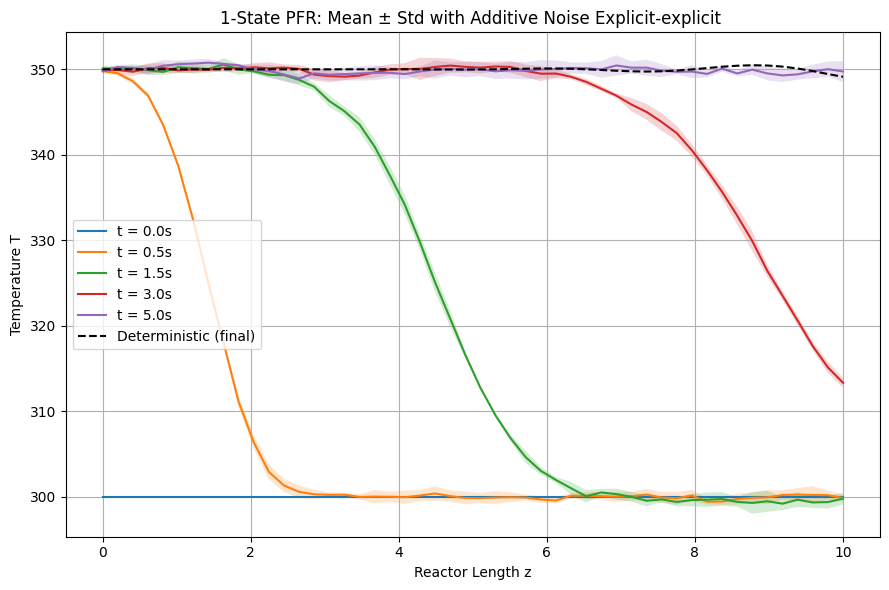

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# --- PFR1 with convection, diffusion and no reaction ---
def PFR1(t, T, u, p):
    Nz = p["Nz"]
    dz = p["dz"]
    v = p["v"]
    DT = p["DT"]
    RT_fun = p.get("RT", lambda T: np.zeros_like(T))

    Tin_val = u if np.isscalar(u) else u(t)

    NT = np.zeros(Nz + 1)
    NT[0] = v * Tin_val
    for j in range(1, Nz):
        NT[j] = v * T[j - 1] - DT * (T[j] - T[j - 1]) / dz
    NT[Nz] = v * T[-1]

    dTdt = -(NT[1:] - NT[:-1]) / dz + RT_fun(T)
    return dTdt

# --- Diffusion term: additive noise on all temperature cells ---
def PFR1_additive_diffusion(t, T, sigma=0.5):
    return np.full_like(T, sigma)

# --- Wiener process generator ---
def StdWienerProcess(tf, N, nw, Ns, seed=0):
    np.random.seed(seed)
    dt = tf / N
    T = np.linspace(0, tf, N + 1)
    dW = np.random.normal(0.0, np.sqrt(dt), size=(nw, N, Ns))
    W = np.zeros((nw, N + 1, Ns))
    W[:, 1:, :] = np.cumsum(dW, axis=1)
    return W, T, dW

# --- Explicit-Explicit SDE solver (Euler–Maruyama) ---
def SDEsolverExplicitExplicit(ffun, gfun, T, x0, W, fargs=(), gargs=()):
    N = len(T)
    nx = len(x0)
    X = np.zeros((nx, N))
    X[:, 0] = x0
    for k in range(N - 1):
        dt = T[k + 1] - T[k]
        dW = W[:, k + 1] - W[:, k]
        f = ffun(T[k], X[:, k], *fargs)
        g = gfun(T[k], X[:, k], *gargs)
        X[:, k + 1] = X[:, k] + f * dt + g * dW
        X[:, k + 1] = np.clip(X[:, k + 1], 1e-6, 1e6)
    return X

# --- Parameters ---
params = {
    "Nz": 50,
    "dz": 0.2,
    "v": 3.0,
    "DT": 0.1,
    "RT": lambda T: 0.0 * T
}

Nz = params["Nz"]
T0 = np.ones(Nz) * 300.0
Tin = 350.0

# --- Time discretization ---
tf = 5.0
N = 200
sigma = 2
seeds = [1, 2, 3, 4, 5]

W, T, _ = StdWienerProcess(tf, N, Nz, Ns=len(seeds), seed=42)

# --- Simulate with additive noise using explicit-explicit ---
paths = []
for i, seed in enumerate(seeds):
    X = SDEsolverExplicitExplicit(
        PFR1, PFR1_additive_diffusion, T, T0, W[:, :, i],
        fargs=(Tin, params), gargs=(sigma,)
    )
    paths.append(X)

paths = np.stack(paths)  # shape: (n_seeds, Nz, N+1)
mean_path = np.mean(paths, axis=0)
std_path = np.std(paths, axis=0)

# --- Deterministic reference solution ---
sol_det = solve_ivp(
    fun=lambda t, T: PFR1(t, T, Tin, params),
    t_span=(0, tf),
    y0=T0,
    method='BDF',
    t_eval=T
)

# --- Plotting ---
z = np.linspace(0, Nz * params["dz"], Nz)
time_indices = [0, 20, 60, 120, 199]

plt.figure(figsize=(9, 6))
for i in time_indices:
    T_mean = mean_path[:, i]
    T_std = std_path[:, i]
    T_det = sol_det.y[:, i]

    plt.plot(z, T_mean, label=f't = {T[i]:.1f}s')
    plt.fill_between(z, T_mean - T_std, T_mean + T_std, alpha=0.2)

plt.plot(z, sol_det.y[:, -1], '--k', label='Deterministic (final)')
plt.xlabel("Reactor Length z")
plt.ylabel("Temperature T")
plt.title("1-State PFR: Mean ± Std with Additive Noise Explicit-explicit ")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


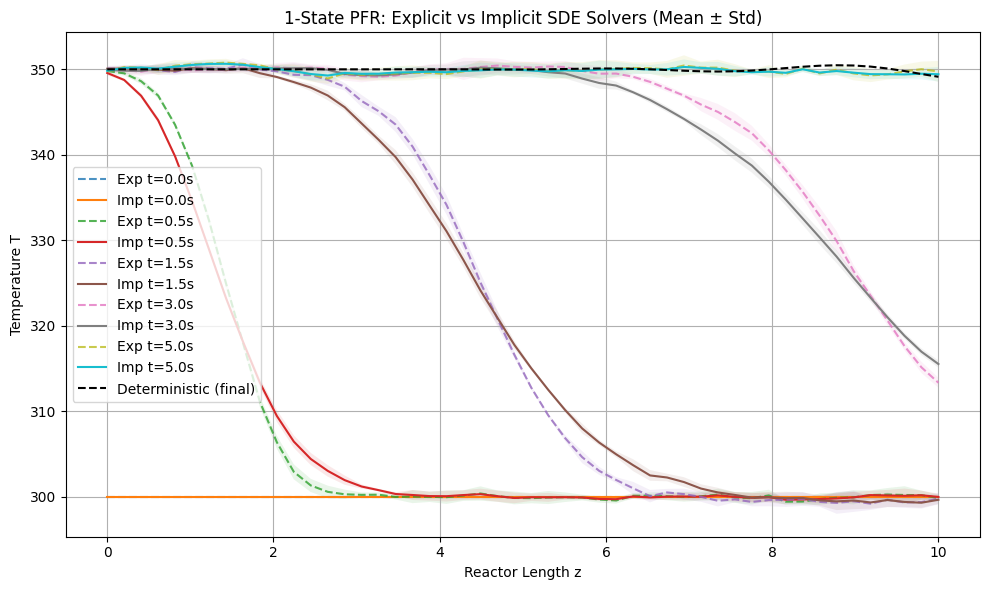

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# --- PFR1 model (1-state temperature only) ---
def PFR1(t, T, u, p):
    Nz = p["Nz"]
    dz = p["dz"]
    v = p["v"]
    DT = p["DT"]
    RT_fun = p.get("RT", lambda T: np.zeros_like(T))
    Tin_val = u if np.isscalar(u) else u(t)

    NT = np.zeros(Nz + 1)
    NT[0] = v * Tin_val
    for j in range(1, Nz):
        NT[j] = v * T[j - 1] - DT * (T[j] - T[j - 1]) / dz
    NT[Nz] = v * T[-1]

    dTdt = -(NT[1:] - NT[:-1]) / dz + RT_fun(T)
    return dTdt

# --- Additive noise function (same for all cells) ---
def PFR1_additive_diffusion(t, T, sigma=1.0):
    return np.full_like(T, sigma)

# --- Wiener process generator ---
def StdWienerProcess(tf, N, nw, Ns, seed=0):
    np.random.seed(seed)
    dt = tf / N
    T = np.linspace(0, tf, N + 1)
    dW = np.random.normal(0.0, np.sqrt(dt), size=(nw, N, Ns))
    W = np.zeros((nw, N + 1, Ns))
    W[:, 1:, :] = np.cumsum(dW, axis=1)
    return W, T, dW

# --- Explicit-Explicit solver ---
def SDEsolverExplicitExplicit(ffun, gfun, T, x0, W, fargs=(), gargs=()):
    N = len(T)
    nx = len(x0)
    X = np.zeros((nx, N))
    X[:, 0] = x0
    for k in range(N - 1):
        dt = T[k + 1] - T[k]
        dW = W[:, k + 1] - W[:, k]
        f = ffun(T[k], X[:, k], *fargs)
        g = gfun(T[k], X[:, k], *gargs)
        X[:, k + 1] = X[:, k] + f * dt + g * dW
        X[:, k + 1] = np.clip(X[:, k + 1], 1e-6, 1e6)
    return X

# --- Newton solver for 1D implicit-explicit ---
def SDENewtonSolver(ffun, t, dt, psi, xinit, tol, maxit, *args):
    x = xinit
    f = ffun(t, x, *args)
    R = x - f * dt - psi
    it = 1
    while np.linalg.norm(R, np.inf) > tol and it <= maxit:
        eps = 1e-6
        nx = len(x)
        J = np.zeros((nx, nx))
        for i in range(nx):
            x_eps = np.copy(x)
            x_eps[i] += eps
            J[:, i] = (ffun(t, x_eps, *args) - f) / eps
        dRdx = np.eye(nx) - J * dt
        dx = np.linalg.solve(dRdx, R)
        x -= dx
        f = ffun(t, x, *args)
        R = x - f * dt - psi
        it += 1
    return x

# --- Implicit-Explicit solver ---
def SDEsolverImplicitExplicit(ffun, gfun, T, x0, W, fargs=(), gargs=()):
    tol = 1e-8
    maxit = 20
    N = len(T)
    nx = len(x0)
    X = np.zeros((nx, N))
    X[:, 0] = x0
    for k in range(N - 1):
        dt = T[k + 1] - T[k]
        dW = W[:, k + 1] - W[:, k]
        g = gfun(T[k], X[:, k], *gargs)
        psi = X[:, k] + g * dW
        f = ffun(T[k], X[:, k], *fargs)
        xinit = psi + f * dt
        xnew = SDENewtonSolver(ffun, T[k + 1], dt, psi, xinit, tol, maxit, *fargs)
        X[:, k + 1] = np.clip(xnew, 1e-6, 1e6)
    return X

# --- Simulation Parameters ---
params = {
    "Nz": 50,
    "dz": 0.2,
    "v": 3.0,
    "DT": 0.1,
    "RT": lambda T: 0.0 * T
}

Nz = params["Nz"]
T0 = np.ones(Nz) * 300.0
Tin = 350.0
tf = 5.0
N = 200
sigma = 2
seeds = [1, 2, 3, 4, 5]
W, T, _ = StdWienerProcess(tf, N, Nz, Ns=len(seeds), seed=42)

# --- Run Explicit Solver ---
paths_exp = []
for i in range(len(seeds)):
    X = SDEsolverExplicitExplicit(
        PFR1, PFR1_additive_diffusion, T, T0, W[:, :, i],
        fargs=(Tin, params), gargs=(sigma,)
    )
    paths_exp.append(X)

# --- Run Implicit Solver ---
paths_imp = []
for i in range(len(seeds)):
    X = SDEsolverImplicitExplicit(
        PFR1, PFR1_additive_diffusion, T, T0, W[:, :, i],
        fargs=(Tin, params), gargs=(sigma,)
    )
    paths_imp.append(X)

paths_exp = np.stack(paths_exp)
paths_imp = np.stack(paths_imp)

mean_exp = np.mean(paths_exp, axis=0)
std_exp = np.std(paths_exp, axis=0)
mean_imp = np.mean(paths_imp, axis=0)
std_imp = np.std(paths_imp, axis=0)

# --- Deterministic Reference ---
sol_det = solve_ivp(lambda t, T: PFR1(t, T, Tin, params), (0, tf), T0, t_eval=T, method='BDF')

# --- Plot ---
z = np.linspace(0, Nz * params["dz"], Nz)
time_indices = [0, 20, 60, 120, 199]

plt.figure(figsize=(10, 6))
for i in time_indices:
    plt.plot(z, mean_exp[:, i], label=f'Exp t={T[i]:.1f}s', linestyle='--', alpha=0.8)
    plt.fill_between(z, mean_exp[:, i] - std_exp[:, i], mean_exp[:, i] + std_exp[:, i], alpha=0.1)

    plt.plot(z, mean_imp[:, i], label=f'Imp t={T[i]:.1f}s', linestyle='-')
    plt.fill_between(z, mean_imp[:, i] - std_imp[:, i], mean_imp[:, i] + std_imp[:, i], alpha=0.1)

plt.plot(z, sol_det.y[:, -1], 'k--', label='Deterministic (final)')
plt.xlabel("Reactor Length z")
plt.ylabel("Temperature T")
plt.title("1-State PFR: Explicit vs Implicit SDE Solvers (Mean ± Std)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


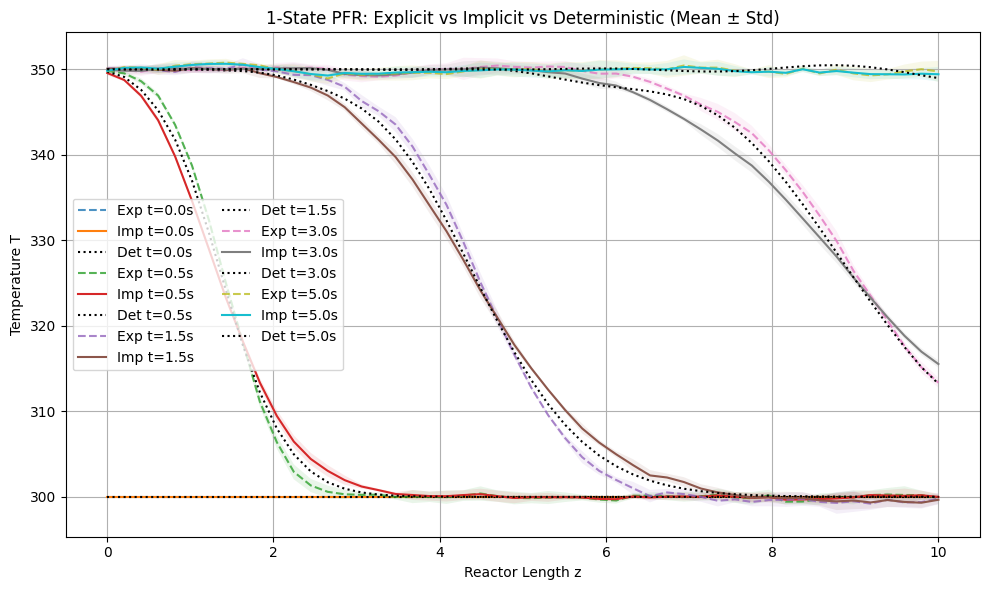

In [62]:
plt.figure(figsize=(10, 6))
for i in time_indices:
    # Explicit-explicit mean ± std
    plt.plot(z, mean_exp[:, i], label=f'Exp t={T[i]:.1f}s', linestyle='--', alpha=0.8)
    plt.fill_between(z, mean_exp[:, i] - std_exp[:, i], mean_exp[:, i] + std_exp[:, i], alpha=0.1)

    # Implicit-explicit mean ± std
    plt.plot(z, mean_imp[:, i], label=f'Imp t={T[i]:.1f}s', linestyle='-')
    plt.fill_between(z, mean_imp[:, i] - std_imp[:, i], mean_imp[:, i] + std_imp[:, i], alpha=0.1)

    # Deterministic solution
    plt.plot(z, sol_det.y[:, i], color='black', linestyle=':', label=f'Det t={T[i]:.1f}s')

plt.xlabel("Reactor Length z")
plt.ylabel("Temperature T")
plt.title("1-State PFR: Explicit vs Implicit vs Deterministic (Mean ± Std)")
plt.legend(ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Define spatial coordinate z
z = np.linspace(0, Nz * params["dz"], Nz)

# Final plot execution
plt.figure(figsize=(9, 6))
for i in time_indices:
    T_mean = mean_path_imp[:, i]
    T_std = std_path_imp[:, i]

    plt.plot(z, T_mean, label=f't = {T[i]:.1f}s')
    plt.fill_between(z, T_mean - T_std, T_mean + T_std, alpha=0.2)

plt.plot(z, sol_det.y[:, -1], '--k', label='Deterministic (final)')
plt.xlabel("Reactor Length z")
plt.ylabel("Temperature T")
plt.title("1-State PFR: Mean ± Std with Additive Noise (Implicit-Explicit)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
